# Bar Naor
# Jacob Maimon
# Final Project - Deep Learning (361.2.1120)
# Task: Super-Resolution Image Enhancement (DIV2K)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Download the HR data from kaggle:**

In [2]:
!pip install torch-fidelity
!pip install -q torchmetrics
!pip install -q torch-fidelity
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [3]:
#Install, upload kaggle.json, download + unzip DIV2K dataset, and check contents
import shutil
import os
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload kaggle.json manually
from google.colab import files
uploaded = files.upload()  # Upload kaggle.json manually

# Step 3: Move to correct location
if "kaggle.json" in uploaded:
    uploaded_filename = "kaggle.json"
else:
    uploaded_filename = list(uploaded.keys())[0]

# Create the .kaggle folder if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move and set permissions
shutil.move(uploaded_filename, "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Step 4: Download and unzip the dataset
!kaggle datasets download -d joe1995/div2k-dataset
!unzip -q div2k-dataset.zip -d data/

# Step 5: Check files
base_path = "data"
print("Top-level folders:", os.listdir(base_path))

hr_path = os.path.join(base_path, "DIV2K_train_HR", "DIV2K_train_HR")

if os.path.exists(hr_path):
    files = os.listdir(hr_path)
    print(f"\n Found {len(files)} high-resolution images.")
    print("Sample filenames:", files[:5])
else:
    print("HR folder not found.")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/joe1995/div2k-dataset
License(s): unknown
 98% 3.64G/3.71G [00:12<00:00, 233MB/s]
100% 3.71G/3.71G [00:12<00:00, 316MB/s]
Top-level folders: ['DIV2K_train_HR', 'DIV2K_valid_HR']

 Found 800 high-resolution images.
Sample filenames: ['0414.png', '0139.png', '0597.png', '0287.png', '0577.png']


**Create LR by ×4 downsampling**:

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)
from PIL import Image

# Create LR images from HR (×4 downsampling)
def create_lr_images_bicubic(hr_dir, lr_dir, scale=4):
    os.makedirs(lr_dir, exist_ok=True)

    for fname in os.listdir(hr_dir):
        if fname.lower().endswith('.png'):
            path_hr = os.path.join(hr_dir, fname)
            path_lr = os.path.join(lr_dir, fname)

            img_hr = Image.open(path_hr)
            w, h = img_hr.size
            img_lr = img_hr.resize((w // scale, h // scale), Image.BICUBIC)
            img_lr.save(path_lr)

# Set paths
lr_path = os.path.join(base_path, "DIV2K_train_LR_bicubic", "X4")
create_lr_images_bicubic(hr_path, lr_path, scale=4)

# Check result
print(f"\nSaved {len(os.listdir(lr_path))} LR images in:", lr_path)
print("Sample LR filenames:", os.listdir(lr_path)[:5])

Device in use: cuda

Saved 800 LR images in: data/DIV2K_train_LR_bicubic/X4
Sample LR filenames: ['0414.png', '0139.png', '0597.png', '0287.png', '0577.png']


# **Base Model**

In [5]:
# Model 1:
import torch
import torch.nn as nn

class FSRCNN(nn.Module):
    def __init__(self, scale_factor=4, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()

        # Feature extraction layer
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, d, kernel_size=5, padding=2),
            nn.PReLU()
        )

        # Shrinking layer
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )

        # Mapping layers (m times)
        mapping_layers = []
        for _ in range(m):
            mapping_layers.append(nn.Conv2d(s, s, kernel_size=3, padding=1))
            mapping_layers.append(nn.PReLU())
        self.mapping = nn.Sequential(*mapping_layers)

        # Expanding layer
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )

        # Deconvolution (upsampling) layer
        self.deconv = nn.ConvTranspose2d(
            d, 3, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor - 1
        )

    def forward(self, x):
        out = self.feature_extraction(x)
        out = self.shrinking(out)
        out = self.mapping(out)
        out = self.expanding(out)
        out = self.deconv(out)
        return out

In [6]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os

# Custom dataset class
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, hr_size=(256, 256)):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.filenames = sorted(os.listdir(lr_dir))
        self.hr_size = hr_size
        self.lr_size = (hr_size[0] // 4, hr_size[1] // 4)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        lr_path = os.path.join(self.lr_dir, fname)
        hr_path = os.path.join(self.hr_dir, fname)

        lr = Image.open(lr_path).convert("RGB").resize(self.lr_size, Image.BICUBIC)
        hr = Image.open(hr_path).convert("RGB").resize(self.hr_size, Image.BICUBIC)

        return {
            'lr': self.to_tensor(lr),
            'hr': self.to_tensor(hr)
        }

# Paths to image folders
lr_path = os.path.join(base_path, "DIV2K_train_LR_bicubic", "X4")
hr_path = os.path.join(base_path, "DIV2K_train_HR", "DIV2K_train_HR")

# Create dataset
full_dataset = SRDataset(lr_dir=lr_path, hr_dir=hr_path)

# Split sizes: 70% train, 15% val, 15% test
total_size = len(full_dataset)
val_size = int(0.15 * total_size)
test_size = int(0.15 * total_size)
train_size = total_size - val_size - test_size

train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=8, shuffle=False)

print(f"Dataset split completed: {train_size} train, {val_size} val, {test_size} test samples.")

Dataset split completed: 560 train, 120 val, 120 test samples.


In [7]:
!pip install -q torch-fidelity
!pip install -q torchmetrics
!pip install -q torch-fidelity

In [8]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

def calculate_psnr(sr, hr):
    mse = nn.functional.mse_loss(sr, hr)
    return 20 * math.log10(1.0) - 10 * math.log10(mse.item()) if mse > 0 else float("inf")

def to_uint8(tensor):
    return tensor.clamp(0, 1).mul(255).to(torch.uint8)

os.makedirs("model1_results", exist_ok=True)
os.makedirs("model1_examples", exist_ok=True)
os.makedirs("model1_examples/test_by_index", exist_ok=True)

seeds = [42, 55, 66]
num_epochs = 10

all_loss_model1, all_psnr_model1, all_ssim_model1, all_fid_model1 = [], [], [], []

for seed in seeds:
    print(f"\n--- Training with seed {seed} ---")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = FSRCNN(scale_factor=4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    fid_metric = FrechetInceptionDistance(feature=2048).cpu()

    loss_list, psnr_list, ssim_list, fid_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()

        for batch in train_loader:
            lr, hr = batch['lr'].to(device), batch['hr'].to(device)
            sr = model(lr)
            _, _, h, w = sr.shape
            hr = hr[:, :, :h, :w]

            loss = criterion(sr, hr)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total_psnr += calculate_psnr(sr, hr)
            total_ssim += structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

            fid_metric.update(to_uint8(sr).cpu(), real=False)
            fid_metric.update(to_uint8(hr).cpu(), real=True)

        avg_loss = epoch_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        avg_ssim = total_ssim / len(train_loader)
        fid_score = fid_metric.compute()

        loss_list.append(avg_loss)
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        fid_list.append(fid_score.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f} | FID: {fid_score.item():.2f}")

    def evaluate(loader, prefix):
        model.eval()
        total_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()
        per_image_metrics = []

        with torch.no_grad():
            for i, batch in enumerate(loader):
                lr, hr = batch['lr'].to(device), batch['hr'].to(device)
                sr = model(lr)
                _, _, h, w = sr.shape
                hr = hr[:, :, :h, :w]

                loss = criterion(sr, hr).item()
                psnr = calculate_psnr(sr, hr)
                ssim = structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

                total_loss += loss
                total_psnr += psnr
                total_ssim += ssim

                fid_metric.update(to_uint8(sr).cpu(), real=False)
                fid_metric.update(to_uint8(hr).cpu(), real=True)
                if prefix == "test":
                    lr_clipped = lr[0].detach().cpu().clamp(0, 1)
                    sr_clipped = sr[0].detach().cpu().clamp(0, 1)
                    hr_clipped = hr[0].detach().cpu().clamp(0, 1)

                    save_image(lr_clipped, f"model1_examples/test_by_index/lr_seed{seed}_idx{i}.png")
                    save_image(sr_clipped, f"model1_examples/test_by_index/sr_seed{seed}_idx{i}.png")
                    save_image(hr_clipped, f"model1_examples/test_by_index/hr_seed{seed}_idx{i}.png")

                    per_image_metrics.append({
                        "index": i,
                        "psnr": psnr,
                        "ssim": ssim
                    })

        avg_loss = total_loss / len(loader)
        avg_psnr = total_psnr / len(loader)
        avg_ssim = total_ssim / len(loader)
        fid = fid_metric.compute().item()

        return avg_loss, avg_psnr, avg_ssim, fid, per_image_metrics

    val_loss, val_psnr, val_ssim, val_fid, _ = evaluate(val_loader, "val")
    test_loss, test_psnr, test_ssim, test_fid, test_image_metrics = evaluate(test_loader, "test")

    print(f"→ Validation: Loss {val_loss:.6f}, PSNR {val_psnr:.2f}, SSIM {val_ssim:.4f}, FID {val_fid:.2f}")
    print(f"→ Test:       Loss {test_loss:.6f}, PSNR {test_psnr:.2f}, SSIM {test_ssim:.4f}, FID {test_fid:.2f}")

    # Save training metrics
    np.save(f"model1_results/loss_seed{seed}.npy", np.array(loss_list))
    np.save(f"model1_results/psnr_seed{seed}.npy", np.array(psnr_list))
    np.save(f"model1_results/ssim_seed{seed}.npy", np.array(ssim_list))
    np.save(f"model1_results/fid_seed{seed}.npy", np.array(fid_list))

    # Save summary metrics
    np.save(f"model1_results/val_metrics_seed{seed}.npy", np.array([val_loss, val_psnr, val_ssim, val_fid]))
    np.save(f"model1_results/test_metrics_seed{seed}.npy", np.array([test_loss, test_psnr, test_ssim, test_fid]))

    # Save per-image test metrics
    np.save(f"model1_results/test_image_metrics_seed{seed}.npy", test_image_metrics)

    # Collect for plots
    all_loss_model1.append(loss_list)
    all_psnr_model1.append(psnr_list)
    all_ssim_model1.append(ssim_list)
    all_fid_model1.append(fid_list)

# Save a backup to drive
!mkdir -p /content/drive/MyDrive/deep_learning_results/model1_results
!mkdir -p /content/drive/MyDrive/deep_learning_results/model1_examples/test_by_index
!cp model1_results/* /content/drive/MyDrive/deep_learning_results/model1_results/
!cp model1_examples/test_by_index/* /content/drive/MyDrive/deep_learning_results/model1_examples/test_by_index/

Using device: Tesla T4

--- Training with seed 42 ---


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 71.7MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/10] - Loss: 0.204471 | PSNR: 7.02 | SSIM: 0.0356 | FID: 417.91
Epoch [2/10] - Loss: 0.093907 | PSNR: 10.61 | SSIM: 0.0573 | FID: 325.25
Epoch [3/10] - Loss: 0.044358 | PSNR: 13.55 | SSIM: 0.2053 | FID: 288.95
Epoch [4/10] - Loss: 0.037451 | PSNR: 14.30 | SSIM: 0.2588 | FID: 309.08
Epoch [5/10] - Loss: 0.033036 | PSNR: 14.86 | SSIM: 0.2641 | FID: 310.20
Epoch [6/10] - Loss: 0.030493 | PSNR: 15.22 | SSIM: 0.2795 | FID: 296.64
Epoch [7/10] - Loss: 0.028489 | PSNR: 15.52 | SSIM: 0.3111 | FID: 282.18
Epoch [8/10] - Loss: 0.026290 | PSNR: 15.86 | SSIM: 0.3309 | FID: 268.00
Epoch [9/10] - Loss: 0.024680 | PSNR: 16.16 | SSIM: 0.3539 | FID: 260.36
Epoch [10/10] - Loss: 0.023987 | PSNR: 16.27 | SSIM: 0.3745 | FID: 256.93
→ Validation: Loss 0.022487, PSNR 16.52, SSIM 0.3494, FID 315.88
→ Test:       Loss 0.024835, PSNR 16.09, SSIM 0.3624, FID 303.50

--- Training with seed 55 ---
Epoch [1/10] - Loss: 0.220712 | PSNR: 6.75 | SSIM: 0.0163 | FID: 357.03
Epoch [2/10] - Loss: 0.052433 | PSNR:

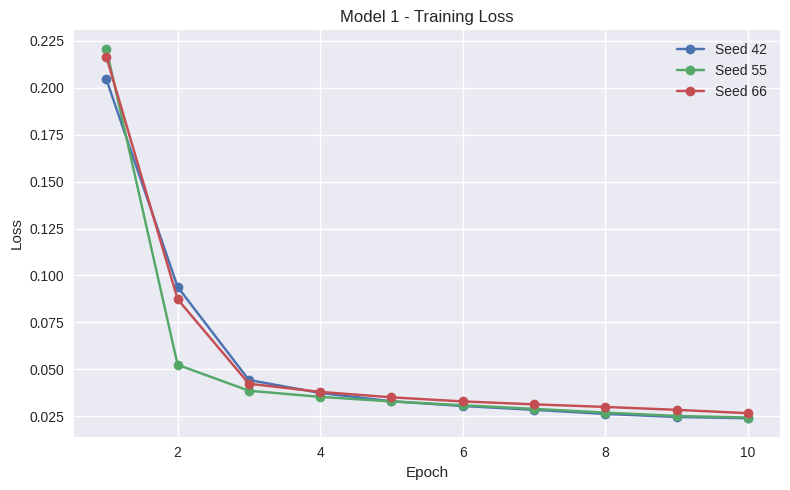

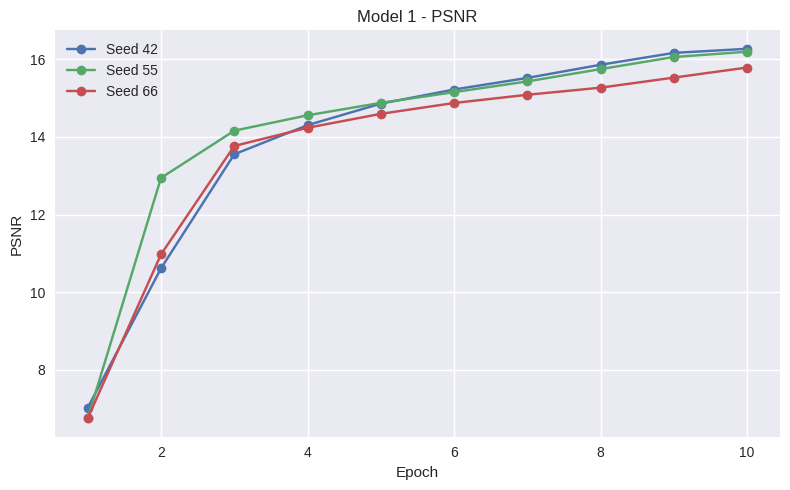

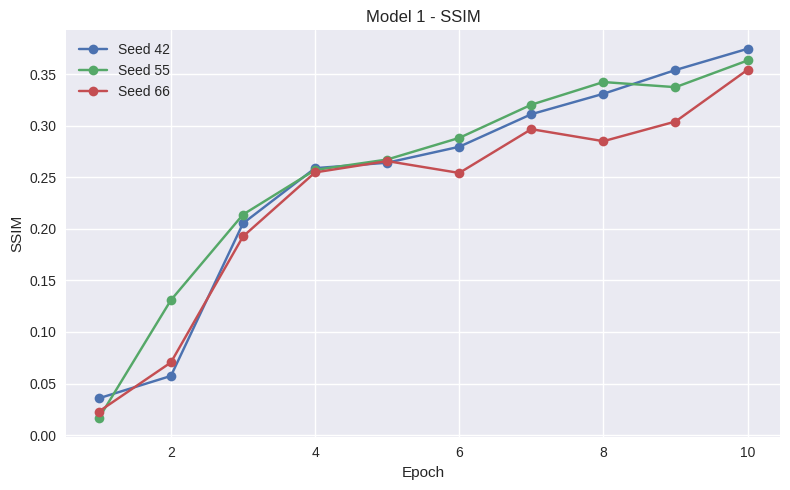

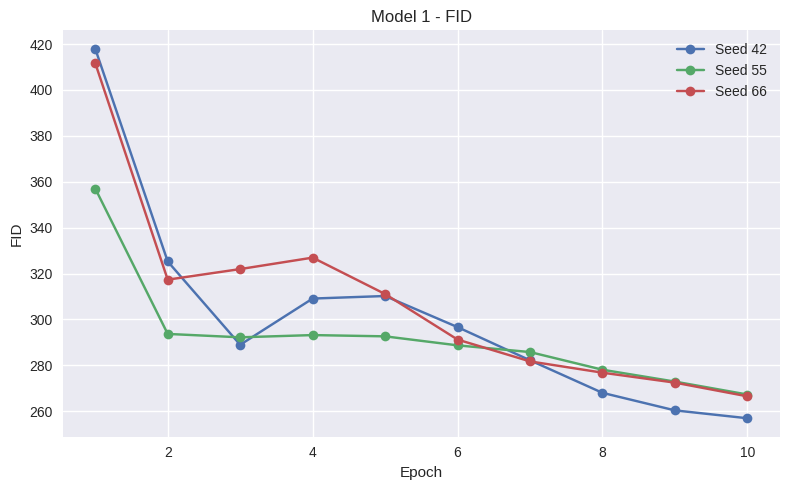

In [9]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

def plot_multiple_runs(all_lists, title, ylabel, filename):
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(8, 5))
    for i, values in enumerate(all_lists):
        plt.plot(epochs, values, marker='o', label=f'Seed {seeds[i]}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.savefig(f"/content/drive/MyDrive/deep_learning_results/model1_results/{filename}")
    plt.show()

# 1. Training Loss (required by 3.4.2.5)
plot_multiple_runs(all_loss_model1, 'Model 1 - Training Loss', 'Loss', 'model1_loss_curve.png')

# 2. PSNR over epochs
plot_multiple_runs(all_psnr_model1, 'Model 1 - PSNR', 'PSNR', 'model1_psnr_curve.png')

# 3. SSIM over epochs
plot_multiple_runs(all_ssim_model1, 'Model 1 - SSIM', 'SSIM', 'model1_ssim_curve.png')

# 4. FID over epochs
plot_multiple_runs(all_fid_model1, 'Model 1 - FID', 'FID', 'model1_fid_curve.png')

In [10]:
import numpy as np
import os

# Convert training results to numpy arrays
psnr_arr = np.array(all_psnr_model1)
ssim_arr = np.array(all_ssim_model1)
fid_arr  = np.array(all_fid_model1)
loss_arr = np.array(all_loss_model1)

mean_psnr = np.mean(psnr_arr, axis=0)
std_psnr  = np.std(psnr_arr, axis=0)
mean_ssim = np.mean(ssim_arr, axis=0)
std_ssim  = np.std(ssim_arr, axis=0)
mean_fid  = np.mean(fid_arr, axis=0)
std_fid   = np.std(fid_arr, axis=0)
mean_loss = np.mean(loss_arr, axis=0)
std_loss  = np.std(loss_arr, axis=0)

lines = []
lines.append("[Model 1] Epoch-wise Training Metrics (Mean ± Std)")
lines.append("Epoch |   PSNR        |   SSIM         |   FID         |   Loss")
lines.append("---------------------------------------------------------------")
for epoch in range(num_epochs):
    lines.append(f"{epoch+1:>5} | {mean_psnr[epoch]:.2f} ± {std_psnr[epoch]:.2f} | "
                 f"{mean_ssim[epoch]:.4f} ± {std_ssim[epoch]:.4f} | "
                 f"{mean_fid[epoch]:.2f} ± {std_fid[epoch]:.2f} | "
                 f"{mean_loss[epoch]:.4f} ± {std_loss[epoch]:.4f}")

# Load Validation metrics
val_metrics = []
for seed in seeds:
    arr = np.load(f"model1_results/val_metrics_seed{seed}.npy")
    val_metrics.append(arr)  # shape [4]
val_metrics = np.array(val_metrics)

mean_val = np.mean(val_metrics, axis=0)
std_val  = np.std(val_metrics, axis=0)

# Load Test metrics
test_metrics = []
for seed in seeds:
    arr = np.load(f"model1_results/test_metrics_seed{seed}.npy")
    test_metrics.append(arr)
test_metrics = np.array(test_metrics)

mean_test = np.mean(test_metrics, axis=0)
std_test  = np.std(test_metrics, axis=0)

# Append Validation summary
lines.append("\n[Model 1] Final Validation Performance (Mean ± Std)")
lines.append("Metric |    Mean ± Std")
lines.append("----------------------")
lines.append(f"Loss   | {mean_val[0]:.4f} ± {std_val[0]:.4f}")
lines.append(f"PSNR   | {mean_val[1]:.2f} ± {std_val[1]:.2f}")
lines.append(f"SSIM   | {mean_val[2]:.4f} ± {std_val[2]:.4f}")
lines.append(f"FID    | {mean_val[3]:.2f} ± {std_val[3]:.2f}")

# Append Test summary
lines.append("\n[Model 1] Final Test Performance (Mean ± Std)")
lines.append("Metric |    Mean ± Std")
lines.append("----------------------")
lines.append(f"Loss   | {mean_test[0]:.4f} ± {std_test[0]:.4f}")
lines.append(f"PSNR   | {mean_test[1]:.2f} ± {std_test[1]:.2f}")
lines.append(f"SSIM   | {mean_test[2]:.4f} ± {std_test[2]:.4f}")
lines.append(f"FID    | {mean_test[3]:.2f} ± {std_test[3]:.2f}")

# Print and save
print("\n".join(lines))

os.makedirs("model1_results", exist_ok=True)
with open("model1_results/model1_summary.txt", "w") as f:
    f.write("\n".join(lines))

# Copy to Google Drive
!cp model1_results/model1_summary.txt /content/drive/MyDrive/deep_learning_results/model1_results/

# Convert lists of results from training to numpy arrays, For later comparison plots
mean_psnr_model1 = np.mean(np.array(all_psnr_model1), axis=0)
mean_ssim_model1 = np.mean(np.array(all_ssim_model1), axis=0)
mean_fid_model1  = np.mean(np.array(all_fid_model1),  axis=0)

mean_test_model1 = mean_test
std_test_model1  = std_test

[Model 1] Epoch-wise Training Metrics (Mean ± Std)
Epoch |   PSNR        |   SSIM         |   FID         |   Loss
---------------------------------------------------------------
    1 | 6.84 ± 0.13 | 0.0249 ± 0.0080 | 395.53 ± 27.34 | 0.2139 ± 0.0069
    2 | 11.51 ± 1.02 | 0.0862 ± 0.0320 | 312.08 ± 13.41 | 0.0779 ± 0.0182
    3 | 13.83 ± 0.25 | 0.2039 ± 0.0087 | 301.03 ± 14.84 | 0.0418 ± 0.0024
    4 | 14.36 ± 0.14 | 0.2568 ± 0.0017 | 309.73 ± 13.79 | 0.0369 ± 0.0011
    5 | 14.78 ± 0.13 | 0.2656 ± 0.0013 | 304.63 ± 8.50 | 0.0337 ± 0.0010
    6 | 15.08 ± 0.15 | 0.2739 ± 0.0144 | 292.18 ± 3.32 | 0.0315 ± 0.0011
    7 | 15.34 ± 0.19 | 0.3093 ± 0.0098 | 283.22 ± 1.81 | 0.0296 ± 0.0013
    8 | 15.62 ± 0.26 | 0.3194 ± 0.0248 | 274.29 ± 4.48 | 0.0278 ± 0.0016
    9 | 15.92 ± 0.28 | 0.3317 ± 0.0208 | 268.57 ± 5.81 | 0.0261 ± 0.0017
   10 | 16.08 ± 0.21 | 0.3639 ± 0.0083 | 263.56 ± 4.70 | 0.0250 ± 0.0012

[Model 1] Final Validation Performance (Mean ± Std)
Metric |    Mean ± Std
------------

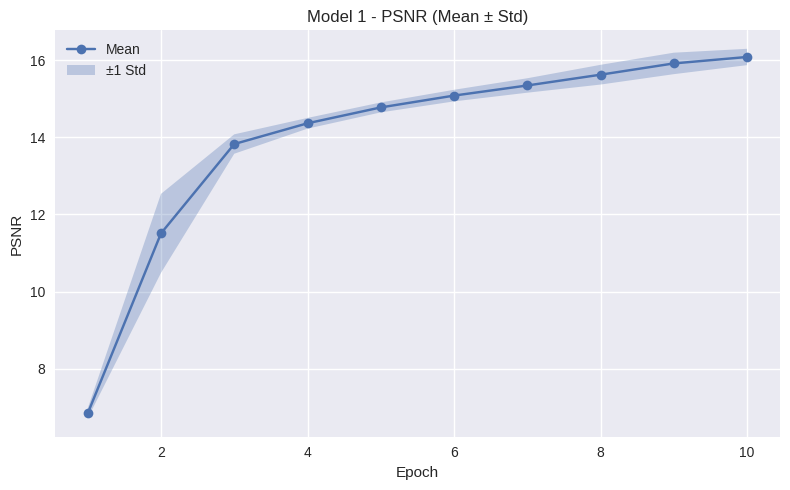

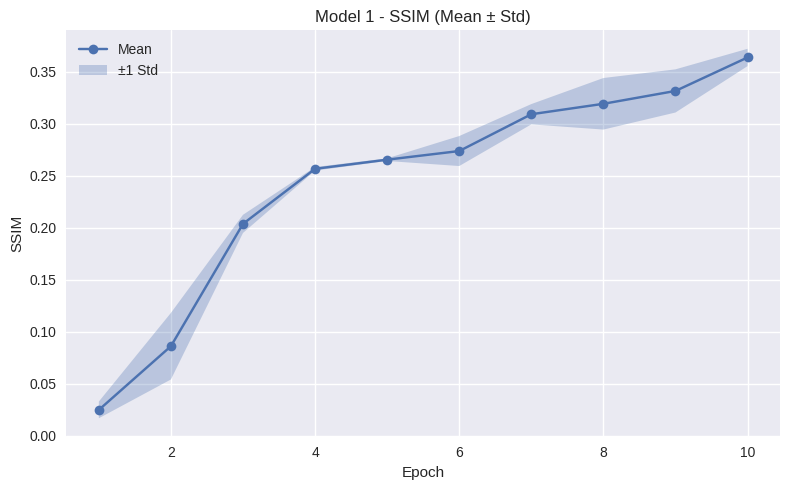

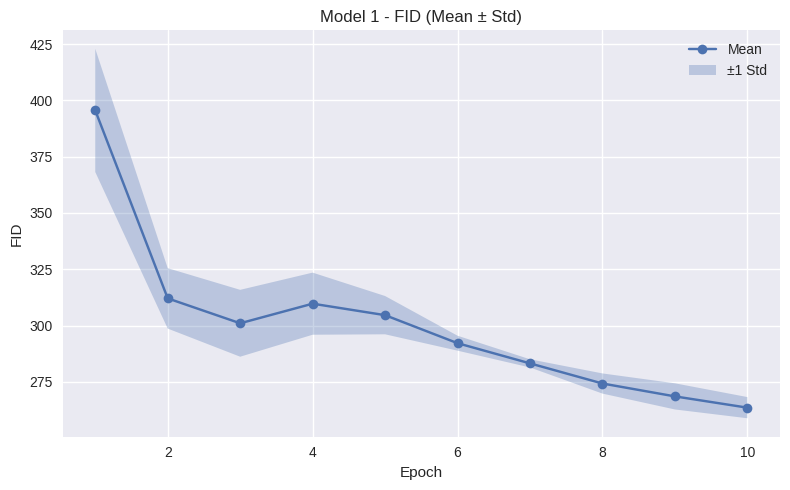

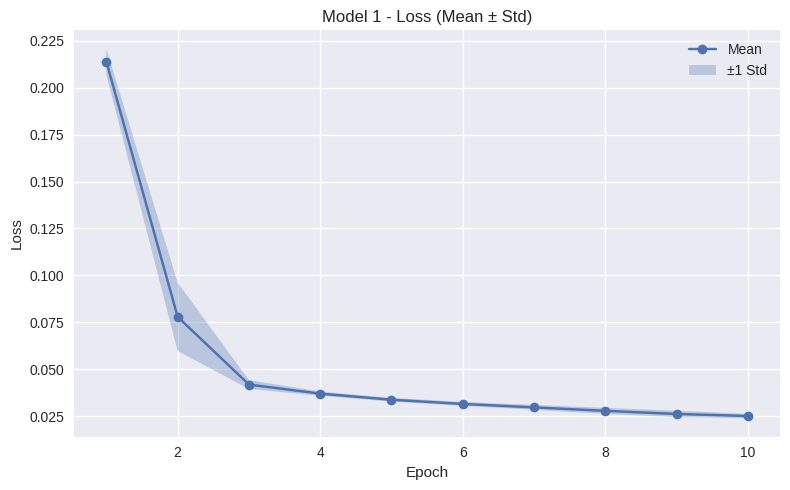

In [11]:
#Plot mean and std
import matplotlib.pyplot as plt

def plot_mean_std(mean_vals, std_vals, title, ylabel, filename):
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_vals, label='Mean', marker='o')
    plt.fill_between(epochs, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3, label='±1 Std')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.savefig(f"/content/drive/MyDrive/deep_learning_results/model1_results/{filename}")
    plt.show()

# Plot mean ± std curves for each metric
plot_mean_std(mean_psnr, std_psnr, 'Model 1 - PSNR (Mean ± Std)', 'PSNR', 'model1_psnr_mean_std.png')
plot_mean_std(mean_ssim, std_ssim, 'Model 1 - SSIM (Mean ± Std)', 'SSIM', 'model1_ssim_mean_std.png')
plot_mean_std(mean_fid, std_fid, 'Model 1 - FID (Mean ± Std)', 'FID', 'model1_fid_mean_std.png')
plot_mean_std(mean_loss, std_loss, 'Model 1 - Loss (Mean ± Std)', 'Loss', 'model1_loss_mean_std.png')

In [12]:
#Base Model structure:
!pip install -q torchsummary
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 56, 64, 64]           4,256
             PReLU-2           [-1, 56, 64, 64]               1
            Conv2d-3           [-1, 12, 64, 64]             684
             PReLU-4           [-1, 12, 64, 64]               1
            Conv2d-5           [-1, 12, 64, 64]           1,308
             PReLU-6           [-1, 12, 64, 64]               1
            Conv2d-7           [-1, 12, 64, 64]           1,308
             PReLU-8           [-1, 12, 64, 64]               1
            Conv2d-9           [-1, 12, 64, 64]           1,308
            PReLU-10           [-1, 12, 64, 64]               1
           Conv2d-11           [-1, 12, 64, 64]           1,308
            PReLU-12           [-1, 12, 64, 64]               1
           Conv2d-13           [-1, 56, 64, 64]             728
            PReLU-14           [-1, 56,


[Model 1] Best PSNR:


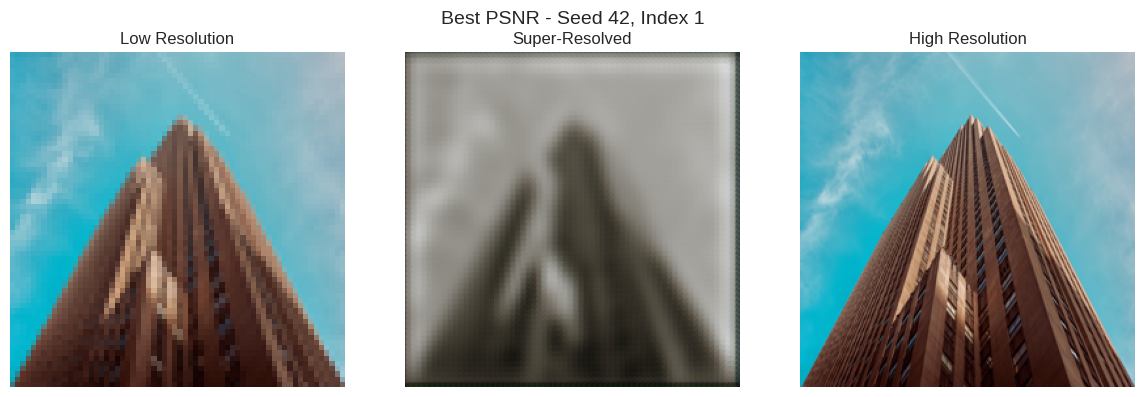

Saved: model1_results/qualitative_examples/best_psnr_seed42_idx1.png

[Model 1] Worst PSNR:


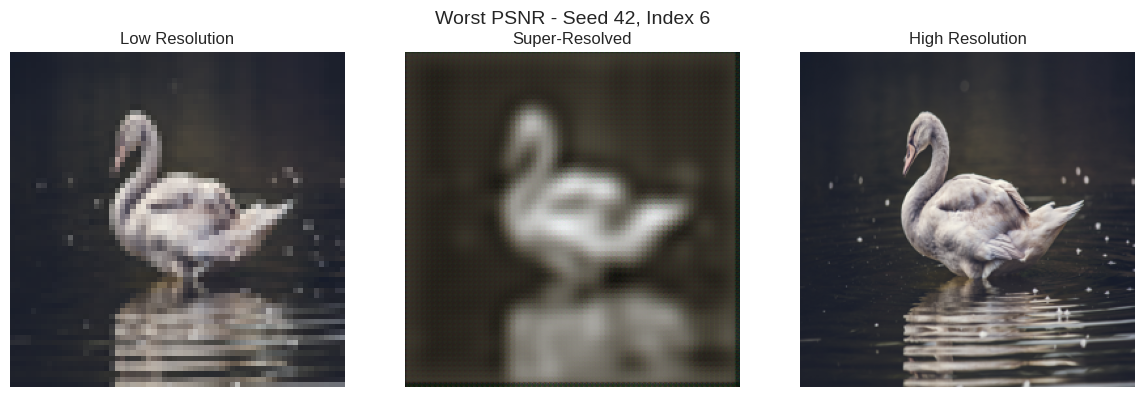

Saved: model1_results/qualitative_examples/worst_psnr_seed42_idx6.png

[Model 1] Best SSIM:


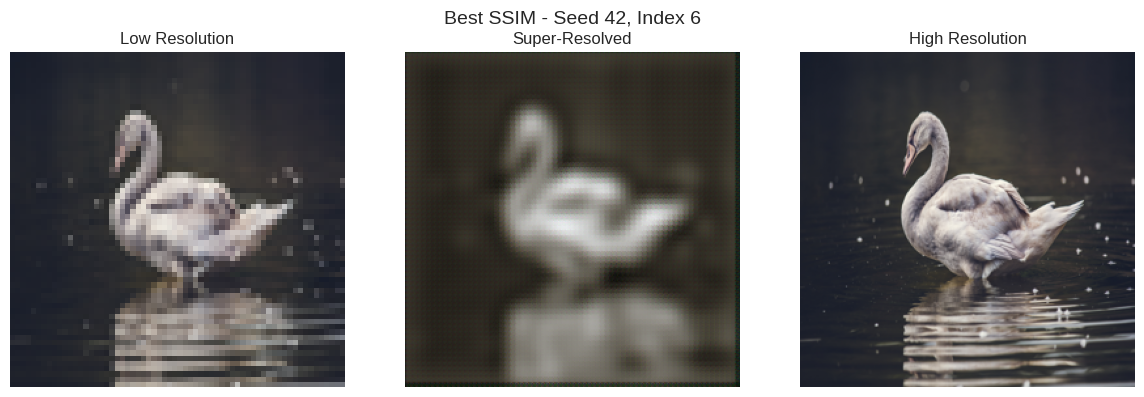

Saved: model1_results/qualitative_examples/best_ssim_seed42_idx6.png

[Model 1] Worst SSIM:


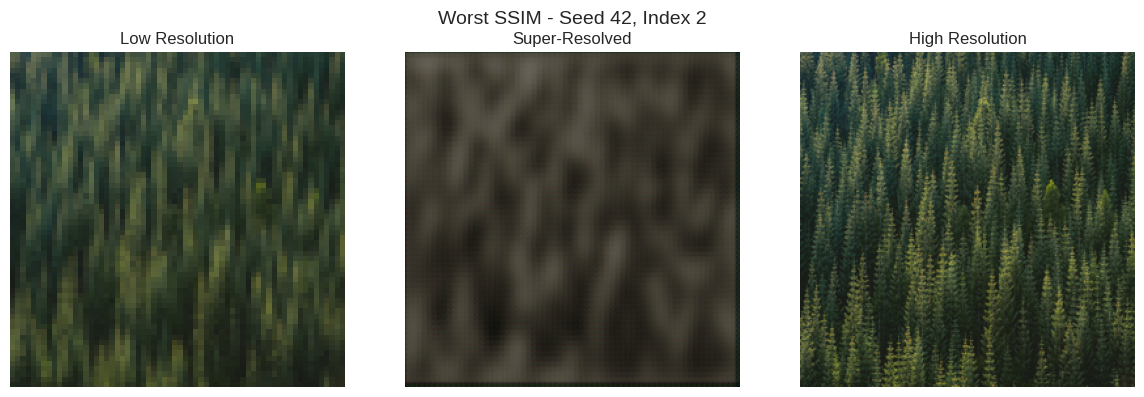

Saved: model1_results/qualitative_examples/worst_ssim_seed42_idx2.png


In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def tensor_to_img(path):
    return np.array(Image.open(path)) / 255.0

def show_and_save_triplet(model_name, seed, index, title_prefix):
    lr = tensor_to_img(f"{model_name}_examples/test_by_index/lr_seed{seed}_idx{index}.png")
    sr = tensor_to_img(f"{model_name}_examples/test_by_index/sr_seed{seed}_idx{index}.png")
    hr = tensor_to_img(f"{model_name}_examples/test_by_index/hr_seed{seed}_idx{index}.png")

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(lr)
    axs[0].set_title("Low Resolution")
    axs[1].imshow(sr)
    axs[1].set_title("Super-Resolved")
    axs[2].imshow(hr)
    axs[2].set_title("High Resolution")
    for ax in axs:
        ax.axis("off")
    plt.suptitle(f"{title_prefix} - Seed {seed}, Index {index}", fontsize=14)
    plt.tight_layout()

    save_dir = f"{model_name}_results/qualitative_examples"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{title_prefix.replace(' ', '_').lower()}_seed{seed}_idx{index}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Saved: {save_path}")

# Load per-image test metrics
model_name = "model1"
seed = 42
metrics = np.load(f"{model_name}_results/test_image_metrics_seed{seed}.npy", allow_pickle=True)

# Best/Worst PSNR
best_psnr  = max(metrics, key=lambda x: x["psnr"])
worst_psnr = min(metrics, key=lambda x: x["psnr"])

# Best/Worst SSIM
best_ssim  = max(metrics, key=lambda x: x["ssim"])
worst_ssim = min(metrics, key=lambda x: x["ssim"])

# Show and save 4 triplets
print("\n[Model 1] Best PSNR:")
show_and_save_triplet(model_name, seed, best_psnr["index"], "Best PSNR")

print("\n[Model 1] Worst PSNR:")
show_and_save_triplet(model_name, seed, worst_psnr["index"], "Worst PSNR")

print("\n[Model 1] Best SSIM:")
show_and_save_triplet(model_name, seed, best_ssim["index"], "Best SSIM")

print("\n[Model 1] Worst SSIM:")
show_and_save_triplet(model_name, seed, worst_ssim["index"], "Worst SSIM")

# **Model 2**

In [14]:
import torch
import torch.nn as nn

class FSRCNN_Residual(nn.Module):
    def __init__(self, scale_factor=4, d=56, s=12, m=8):
        super(FSRCNN_Residual, self).__init__()

        self.scale = scale_factor

        # Feature extraction
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, d, kernel_size=5, padding=2),
            nn.PReLU()
        )

        # Shrinking
        self.shrinking = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )

        # Mapping layers (deeper: m=8)
        mapping_layers = []
        for _ in range(m):
            mapping_layers.append(nn.Conv2d(s, s, kernel_size=3, padding=1))
            mapping_layers.append(nn.PReLU())
        self.mapping = nn.Sequential(*mapping_layers)

        # Expanding
        self.expanding = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )

        # Upsampling
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='bicubic', align_corners=False),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)  # refining layer after residual
        )

        # Final deconvolution
        self.deconv = nn.ConvTranspose2d(
            d, 3, kernel_size=9, stride=scale_factor, padding=4, output_padding=scale_factor - 1
        )

    def forward(self, x):
        # Residual upsampling path
        residual = self.upsample(x)

        # Main path
        out = self.feature_extraction(x)
        out = self.shrinking(out)
        out = self.mapping(out)
        out = self.expanding(out)
        out = self.deconv(out)

        # Add residual
        out += residual

        return out

In [15]:
# === Full Training Block for Model 2 ===
!pip install -q torchmetrics
!pip install -q torch-fidelity

import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.image.fid import FrechetInceptionDistance
import torchvision.models as models
import torchvision.transforms as T

# VGG Perceptual Loss
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:9]
        self.vgg = vgg.eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    def forward(self, sr, hr):
        sr_resized = nn.functional.interpolate(sr, size=(224, 224), mode='bilinear', align_corners=False)
        hr_resized = nn.functional.interpolate(hr, size=(224, 224), mode='bilinear', align_corners=False)
        sr_norm = self.normalize(sr_resized)
        hr_norm = self.normalize(hr_resized)
        return nn.functional.mse_loss(self.vgg(sr_norm), self.vgg(hr_norm))

# PSNR and utility

def calculate_psnr(sr, hr):
    mse = nn.functional.mse_loss(sr, hr)
    return 20 * math.log10(1.0) - 10 * math.log10(mse.item()) if mse > 0 else float("inf")

def to_uint8(tensor):
    return tensor.clamp(0, 1).mul(255).to(torch.uint8)

# === Configuration ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

lambda_p = 0.01
num_epochs = 10
seeds = [42, 55, 66]

os.makedirs("model2_results", exist_ok=True)
os.makedirs("model2_examples/test_by_index", exist_ok=True)

all_loss_model2, all_psnr_model2, all_ssim_model2, all_fid_model2 = [], [], [], []

for seed in seeds:
    print(f"\n--- Training Model 2 with seed {seed} ---")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model2 = FSRCNN_Residual(scale_factor=4).to(device)
    mse_loss = nn.MSELoss()
    perc_loss = VGGPerceptualLoss().to(device)
    optimizer = optim.Adam(model2.parameters(), lr=1e-4)
    fid_metric = FrechetInceptionDistance(feature=2048).cpu()

    loss_list, psnr_list, ssim_list, fid_list = [], [], [], []

    for epoch in range(num_epochs):
        model2.train()
        epoch_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()

        for batch in train_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            sr = model2(lr)
            _, _, h, w = sr.shape
            hr = hr[:, :, :h, :w]

            loss = mse_loss(sr, hr) + lambda_p * perc_loss(sr, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total_psnr += calculate_psnr(sr, hr)
            total_ssim += structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

            fid_metric.update(to_uint8(sr).cpu(), real=False)
            fid_metric.update(to_uint8(hr).cpu(), real=True)

        avg_loss = epoch_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        avg_ssim = total_ssim / len(train_loader)
        fid_score = fid_metric.compute()

        loss_list.append(avg_loss)
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        fid_list.append(fid_score.item())

        print(f"Model 2– Seed {seed}– Epoch [{epoch+1}/{num_epochs}]- Loss: {avg_loss:.6f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f} | FID: {fid_score.item():.2f}")

    # Evaluation on val and test with image saving
    def evaluate(loader, prefix):
        model2.eval()
        total_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()
        per_image_metrics = []

        with torch.no_grad():
            for i, batch in enumerate(loader):
                lr, hr = batch['lr'].to(device), batch['hr'].to(device)
                sr = model2(lr)
                _, _, h, w = sr.shape
                hr = hr[:, :, :h, :w]

                loss = mse_loss(sr, hr) + lambda_p * perc_loss(sr, hr)
                psnr = calculate_psnr(sr, hr)
                ssim = structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

                total_loss += loss.item()
                total_psnr += psnr
                total_ssim += ssim

                fid_metric.update(to_uint8(sr).cpu(), real=False)
                fid_metric.update(to_uint8(hr).cpu(), real=True)

                if prefix == "test":
                    save_image(lr[0], f"model2_examples/test_by_index/lr_seed{seed}_idx{i}.png")
                    save_image(sr[0], f"model2_examples/test_by_index/sr_seed{seed}_idx{i}.png")
                    save_image(hr[0], f"model2_examples/test_by_index/hr_seed{seed}_idx{i}.png")
                    per_image_metrics.append({"index": i, "psnr": psnr, "ssim": ssim})

        avg_loss = total_loss / len(loader)
        avg_psnr = total_psnr / len(loader)
        avg_ssim = total_ssim / len(loader)
        fid = fid_metric.compute().item()

        return avg_loss, avg_psnr, avg_ssim, fid, per_image_metrics

    val_loss, val_psnr, val_ssim, val_fid, _ = evaluate(val_loader, "val")
    test_loss, test_psnr, test_ssim, test_fid, test_image_metrics = evaluate(test_loader, "test")

    print(f"\n→ Validation: Loss {val_loss:.6f}, PSNR {val_psnr:.2f}, SSIM {val_ssim:.4f}, FID {val_fid:.2f}")
    print(f"→ Test:       Loss {test_loss:.6f}, PSNR {test_psnr:.2f}, SSIM {test_ssim:.4f}, FID {test_fid:.2f}")

    np.save(f"model2_results/loss_seed{seed}.npy", np.array(loss_list))
    np.save(f"model2_results/psnr_seed{seed}.npy", np.array(psnr_list))
    np.save(f"model2_results/ssim_seed{seed}.npy", np.array(ssim_list))
    np.save(f"model2_results/fid_seed{seed}.npy", np.array(fid_list))
    np.save(f"model2_results/val_metrics_seed{seed}.npy", np.array([val_loss, val_psnr, val_ssim, val_fid]))
    np.save(f"model2_results/test_metrics_seed{seed}.npy", np.array([test_loss, test_psnr, test_ssim, test_fid]))
    np.save(f"model2_results/test_image_metrics_seed{seed}.npy", test_image_metrics)

    all_loss_model2.append(loss_list)
    all_psnr_model2.append(psnr_list)
    all_ssim_model2.append(ssim_list)
    all_fid_model2.append(fid_list)

# Backup to Drive
!mkdir -p /content/drive/MyDrive/deep_learning_results/model2_results
!mkdir -p /content/drive/MyDrive/deep_learning_results/model2_examples/test_by_index
!cp model2_results/* /content/drive/MyDrive/deep_learning_results/model2_results/
!cp model2_examples/test_by_index/* /content/drive/MyDrive/deep_learning_results/model2_examples/test_by_index/


Using device: Tesla T4

--- Training Model 2 with seed 42 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import

Model 2– Seed 42– Epoch [1/10]- Loss: 0.157777 | PSNR: 11.12 | SSIM: 0.2175 | FID: 205.84
Model 2– Seed 42– Epoch [2/10]- Loss: 0.108887 | PSNR: 14.14 | SSIM: 0.3330 | FID: 195.08
Model 2– Seed 42– Epoch [3/10]- Loss: 0.098417 | PSNR: 15.10 | SSIM: 0.4124 | FID: 190.83
Model 2– Seed 42– Epoch [4/10]- Loss: 0.092478 | PSNR: 15.76 | SSIM: 0.4004 | FID: 183.91
Model 2– Seed 42– Epoch [5/10]- Loss: 0.085772 | PSNR: 16.73 | SSIM: 0.4476 | FID: 167.70
Model 2– Seed 42– Epoch [6/10]- Loss: 0.079248 | PSNR: 17.87 | SSIM: 0.4421 | FID: 150.61
Model 2– Seed 42– Epoch [7/10]- Loss: 0.075271 | PSNR: 18.49 | SSIM: 0.4705 | FID: 142.46
Model 2– Seed 42– Epoch [8/10]- Loss: 0.072502 | PSNR: 18.96 | SSIM: 0.4886 | FID: 136.45
Model 2– Seed 42– Epoch [9/10]- Loss: 0.070368 | PSNR: 19.34 | SSIM: 0.4957 | FID: 132.34
Model 2– Seed 42– Epoch [10/10]- Loss: 0.068486 | PSNR: 19.64 | SSIM: 0.5039 | FID: 128.48

→ Validation: Loss 0.064751, PSNR 19.85, SSIM 0.4940, FID 192.00
→ Test:       Loss 0.066159, PSNR

In [16]:
print(model2)

FSRCNN_Residual(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): PReLU(num_parameters=1)
    (12): Conv2d(12, 12, kernel_size=(

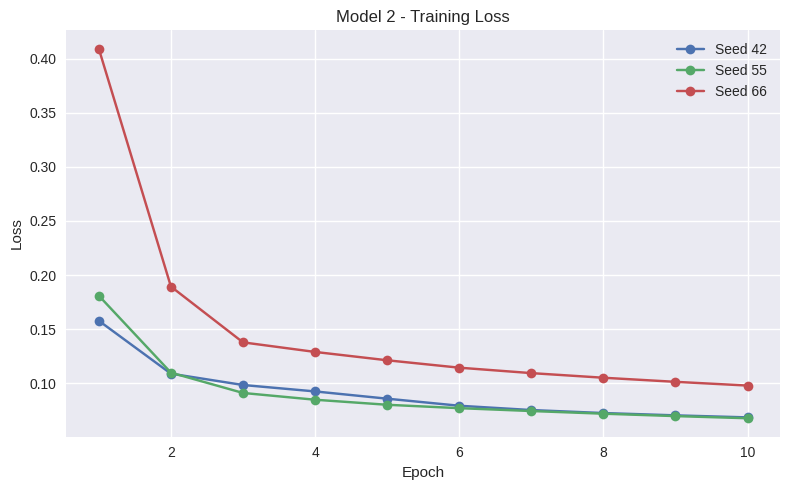

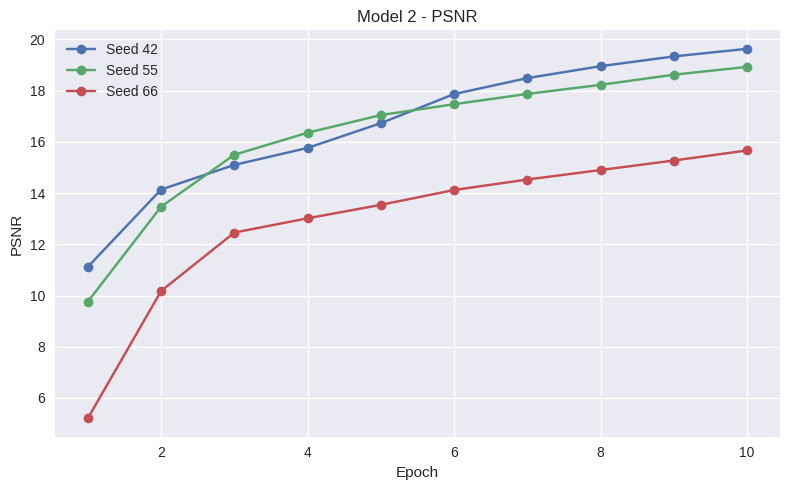

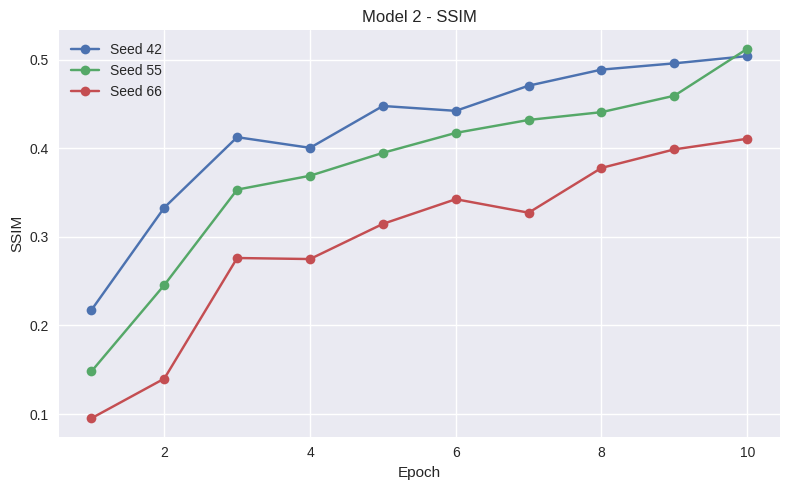

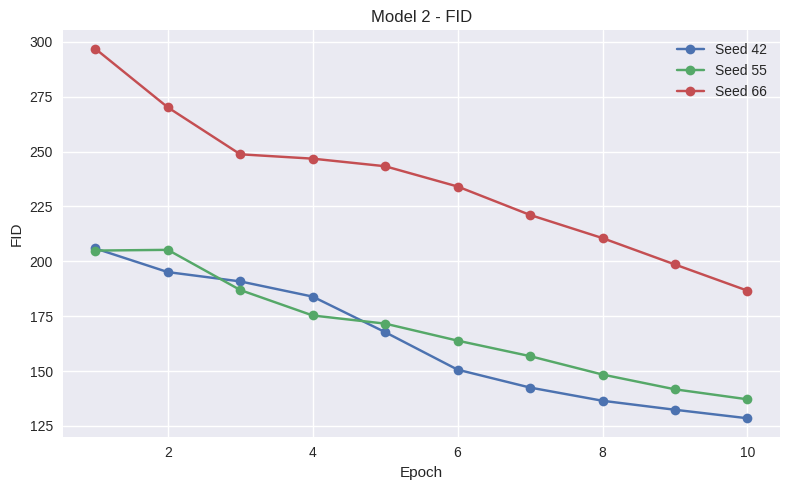

In [17]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

def plot_multiple_runs(all_lists, title, ylabel, filename, colors=None):
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(8, 5))
    for i, values in enumerate(all_lists):
        color = colors[i] if colors else None
        plt.plot(epochs, values, marker='o', label=f'Seed {seeds[i]}', color=color)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save locally and to Drive
    plt.savefig(filename)
    plt.savefig(f"/content/drive/MyDrive/deep_learning_results/model2_results/{filename}")
    plt.show()

# Plot for Model 2
plot_multiple_runs(all_loss_model2, 'Model 2 - Training Loss', 'Loss', 'model2_loss_curve.png')
plot_multiple_runs(all_psnr_model2, 'Model 2 - PSNR', 'PSNR', 'model2_psnr_curve.png')
plot_multiple_runs(all_ssim_model2, 'Model 2 - SSIM', 'SSIM', 'model2_ssim_curve.png')
plot_multiple_runs(all_fid_model2, 'Model 2 - FID', 'FID', 'model2_fid_curve.png')

In [18]:
# Calculate mean and std for all epochs across the 3 seeds

import numpy as np
import os

# === Convert per-epoch lists to arrays ===
psnr_arr = np.array(all_psnr_model2)
ssim_arr = np.array(all_ssim_model2)
fid_arr  = np.array(all_fid_model2)
loss_arr = np.array(all_loss_model2)

mean_psnr = np.mean(psnr_arr, axis=0)
std_psnr  = np.std(psnr_arr, axis=0)
mean_ssim = np.mean(ssim_arr, axis=0)
std_ssim  = np.std(ssim_arr, axis=0)
mean_fid  = np.mean(fid_arr, axis=0)
std_fid   = np.std(fid_arr, axis=0)
mean_loss = np.mean(loss_arr, axis=0)
std_loss  = np.std(loss_arr, axis=0)

# === Summary output ===
lines = []
lines.append("[Model 2] Epoch-wise Training Metrics (Mean ± Std)")
lines.append("Epoch |   PSNR        |   SSIM         |   FID         |   Loss")
lines.append("---------------------------------------------------------------")
for epoch in range(num_epochs):
    lines.append(f"{epoch+1:>5} | {mean_psnr[epoch]:.2f} ± {std_psnr[epoch]:.2f} | "
                 f"{mean_ssim[epoch]:.4f} ± {std_ssim[epoch]:.4f} | "
                 f"{mean_fid[epoch]:.2f} ± {std_fid[epoch]:.2f} | "
                 f"{mean_loss[epoch]:.4f} ± {std_loss[epoch]:.4f}")

# === Validation Metrics ===
val_metrics = []
for seed in seeds:
    val = np.load(f"model2_results/val_metrics_seed{seed}.npy")
    val_metrics.append(val)
val_metrics = np.array(val_metrics)

mean_val = np.mean(val_metrics, axis=0)
std_val  = np.std(val_metrics, axis=0)

lines.append("\n[Model 2] Final Validation Performance (Mean ± Std)")
lines.append("Metric |    Mean ± Std")
lines.append("----------------------")
lines.append(f"Loss   | {mean_val[0]:.4f} ± {std_val[0]:.4f}")
lines.append(f"PSNR   | {mean_val[1]:.2f} ± {std_val[1]:.2f}")
lines.append(f"SSIM   | {mean_val[2]:.4f} ± {std_val[2]:.4f}")
lines.append(f"FID    | {mean_val[3]:.2f} ± {std_val[3]:.2f}")

# === Test Metrics ===
test_metrics = []
for seed in seeds:
    test = np.load(f"model2_results/test_metrics_seed{seed}.npy")
    test_metrics.append(test)
test_metrics = np.array(test_metrics)

mean_test = np.mean(test_metrics, axis=0)
std_test  = np.std(test_metrics, axis=0)

lines.append("\n[Model 2] Final Test Performance (Mean ± Std)")
lines.append("Metric |    Mean ± Std")
lines.append("----------------------")
lines.append(f"Loss   | {mean_test[0]:.4f} ± {std_test[0]:.4f}")
lines.append(f"PSNR   | {mean_test[1]:.2f} ± {std_test[1]:.2f}")
lines.append(f"SSIM   | {mean_test[2]:.4f} ± {std_test[2]:.4f}")
lines.append(f"FID    | {mean_test[3]:.2f} ± {std_test[3]:.2f}")

# === Print & Save ===
print("\n".join(lines))

os.makedirs("model2_results", exist_ok=True)
with open("model2_results/model2_summary.txt", "w") as f:
    f.write("\n".join(lines))

# Save to Drive
!cp model2_results/model2_summary.txt /content/drive/MyDrive/deep_learning_results/model2_results/

# For later comparison plots
mean_psnr_model2 = np.mean(np.array(all_psnr_model2), axis=0)
mean_ssim_model2 = np.mean(np.array(all_ssim_model2), axis=0)
mean_fid_model2  = np.mean(np.array(all_fid_model2),  axis=0)

mean_test_model2 = mean_test
std_test_model2  = std_test

[Model 2] Epoch-wise Training Metrics (Mean ± Std)
Epoch |   PSNR        |   SSIM         |   FID         |   Loss
---------------------------------------------------------------
    1 | 8.70 ± 2.53 | 0.1537 ± 0.0500 | 235.85 ± 43.12 | 0.2493 ± 0.1134
    2 | 12.60 ± 1.73 | 0.2395 ± 0.0789 | 223.48 ± 33.25 | 0.1360 ± 0.0377
    3 | 14.35 ± 1.35 | 0.3472 ± 0.0558 | 208.84 ± 28.28 | 0.1091 ± 0.0205
    4 | 15.05 ± 1.46 | 0.3481 ± 0.0533 | 201.99 ± 31.86 | 0.1021 ± 0.0193
    5 | 15.77 ± 1.58 | 0.3856 ± 0.0547 | 194.20 ± 34.76 | 0.0957 ± 0.0182
    6 | 16.49 ± 1.68 | 0.4006 ± 0.0424 | 182.84 ± 36.63 | 0.0902 ± 0.0171
    7 | 16.97 ± 1.74 | 0.4098 ± 0.0605 | 173.45 ± 34.21 | 0.0863 ± 0.0163
    8 | 17.36 ± 1.77 | 0.4357 ± 0.0454 | 165.14 ± 32.49 | 0.0832 ± 0.0155
    9 | 17.74 ± 1.77 | 0.4512 ± 0.0400 | 157.52 ± 29.26 | 0.0805 ± 0.0148
   10 | 18.08 ± 1.73 | 0.4755 ± 0.0460 | 150.74 ± 25.62 | 0.0780 ± 0.0141

[Model 2] Final Validation Performance (Mean ± Std)
Metric |    Mean ± Std
------

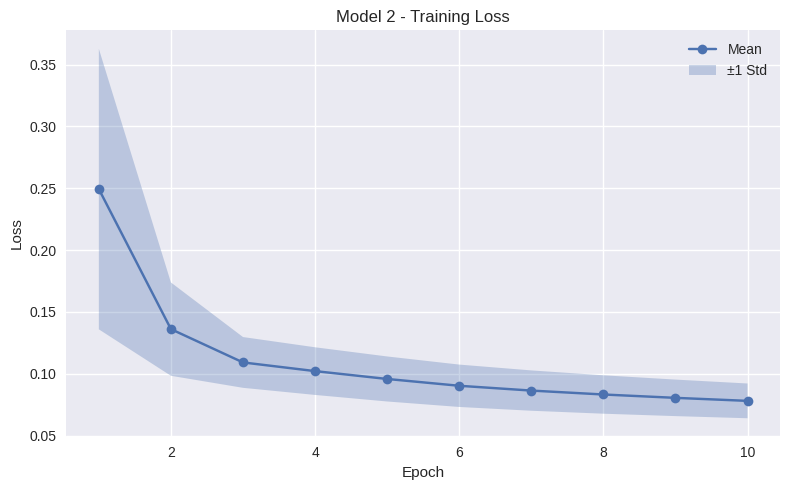

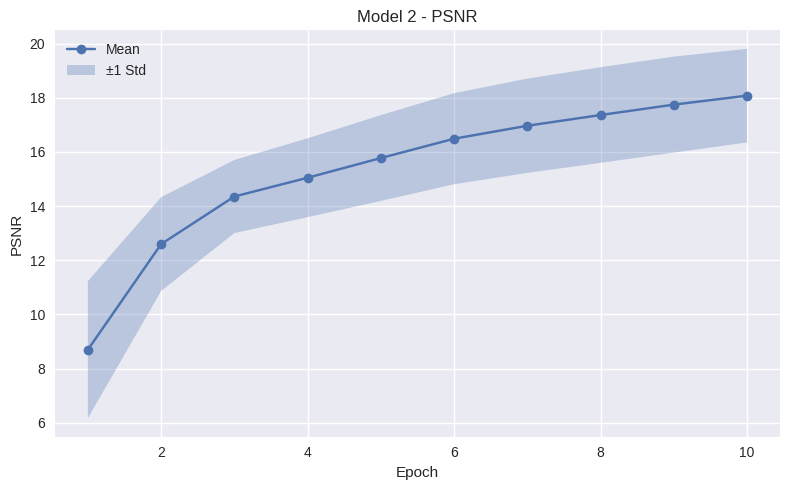

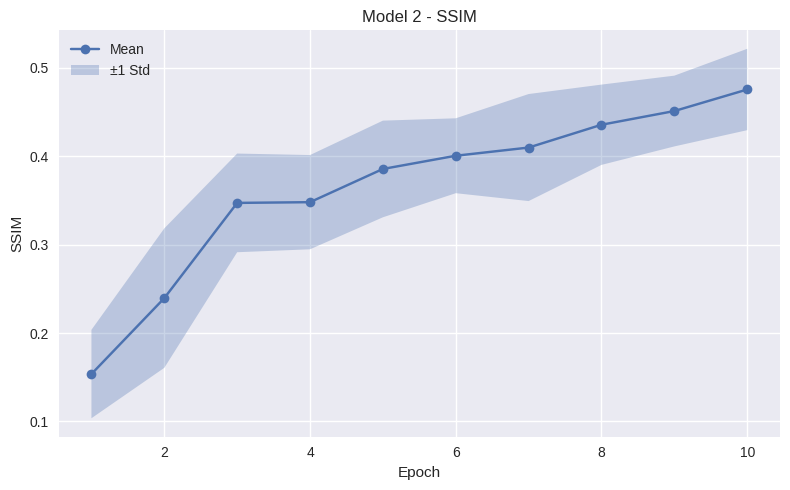

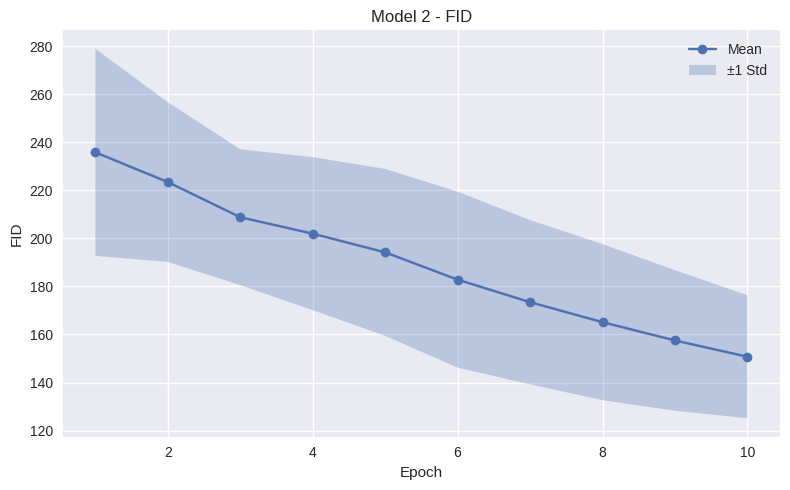

In [19]:
#Plot mean and std
import matplotlib.pyplot as plt
import numpy as np
import os

# Load arrays
psnr_arr = np.array(all_psnr_model2)
ssim_arr = np.array(all_ssim_model2)
fid_arr  = np.array(all_fid_model2)
loss_arr = np.array(all_loss_model2)

# Compute mean and std
mean_psnr = np.mean(psnr_arr, axis=0)
std_psnr  = np.std(psnr_arr, axis=0)
mean_ssim = np.mean(ssim_arr, axis=0)
std_ssim  = np.std(ssim_arr, axis=0)
mean_fid  = np.mean(fid_arr, axis=0)
std_fid   = np.std(fid_arr, axis=0)
mean_loss = np.mean(loss_arr, axis=0)
std_loss  = np.std(loss_arr, axis=0)

# Helper plotting function
def plot_with_std(mean_values, std_values, title, ylabel, filename):
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_values, label='Mean', marker='o')
    plt.fill_between(epochs, mean_values - std_values, mean_values + std_values, alpha=0.3, label='±1 Std')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.savefig(f"/content/drive/MyDrive/deep_learning_results/model2_results/{filename}")
    plt.show()

# Plot each metric
plot_with_std(mean_loss, std_loss, "Model 2 - Training Loss", "Loss", "model2_loss_mean_std.png")
plot_with_std(mean_psnr, std_psnr, "Model 2 - PSNR", "PSNR", "model2_psnr_mean_std.png")
plot_with_std(mean_ssim, std_ssim, "Model 2 - SSIM", "SSIM", "model2_ssim_mean_std.png")
plot_with_std(mean_fid, std_fid, "Model 2 - FID", "FID", "model2_fid_mean_std.png")

# For comparison calculation
mean_loss_model2 = mean_loss
mean_psnr_model2 = mean_psnr
mean_ssim_model2 = mean_ssim
mean_fid_model2  = mean_fid

std_loss_model2 = std_loss
std_psnr_model2 = std_psnr
std_ssim_model2 = std_ssim
std_fid_model2  = std_fid

In [20]:
from torchsummary import summary
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 56, 64, 64]           4,256
             PReLU-2           [-1, 56, 64, 64]               1
            Conv2d-3           [-1, 12, 64, 64]             684
             PReLU-4           [-1, 12, 64, 64]               1
            Conv2d-5           [-1, 12, 64, 64]           1,308
             PReLU-6           [-1, 12, 64, 64]               1
            Conv2d-7           [-1, 12, 64, 64]           1,308
             PReLU-8           [-1, 12, 64, 64]               1
            Conv2d-9           [-1, 12, 64, 64]           1,308
            PReLU-10           [-1, 12, 64, 64]               1
           Conv2d-11           [-1, 12, 64, 64]           1,308
            PReLU-12           [-1, 12, 64, 64]               1
           Conv2d-13           [-1, 56, 64, 64]             728
            PReLU-14           [-1, 56,


[Model 2] Best PSNR:


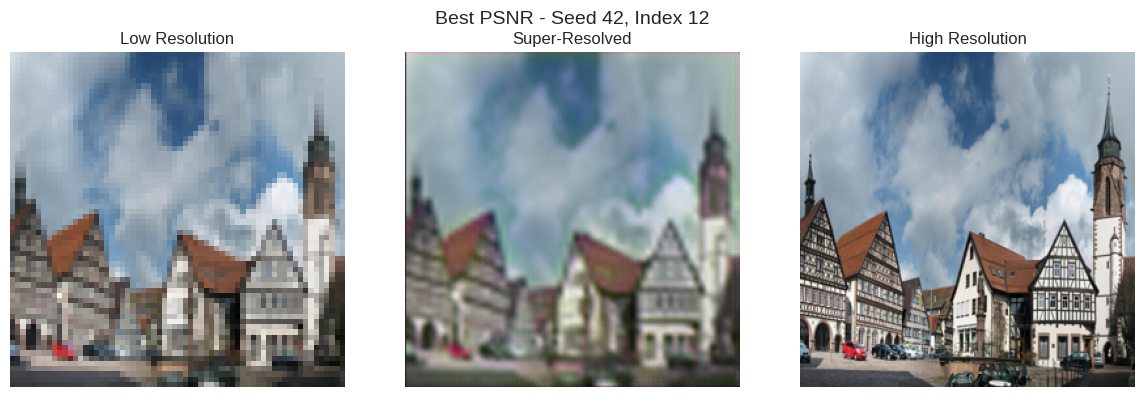

Saved: model2_results/qualitative_examples/best_psnr_seed42_idx12.png

[Model 2] Worst PSNR:


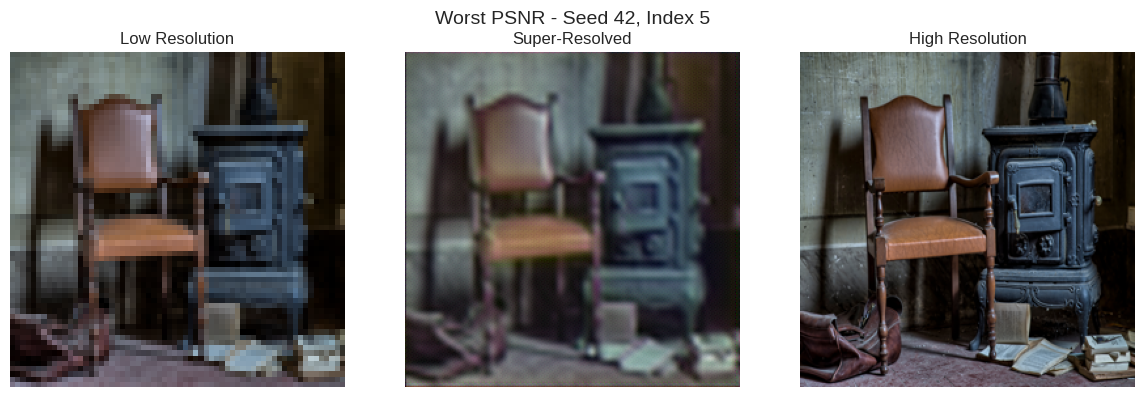

Saved: model2_results/qualitative_examples/worst_psnr_seed42_idx5.png

[Model 2] Best SSIM:


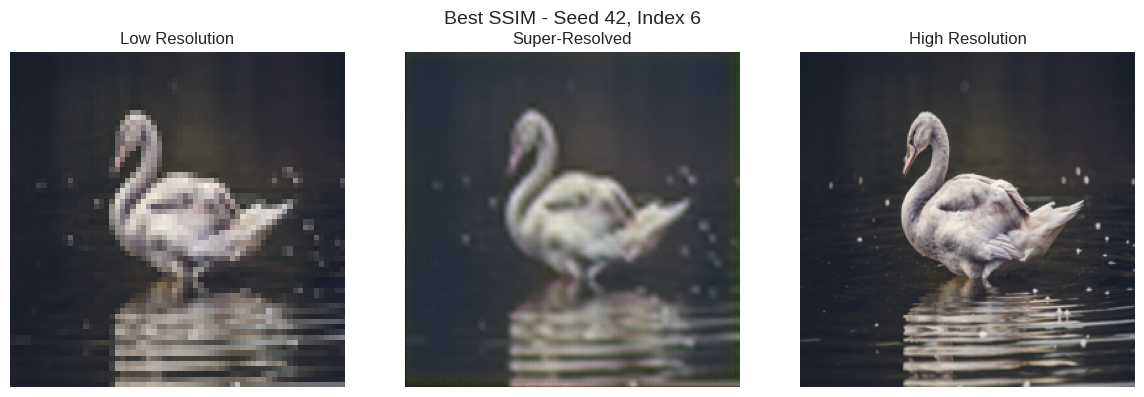

Saved: model2_results/qualitative_examples/best_ssim_seed42_idx6.png

[Model 2] Worst SSIM:


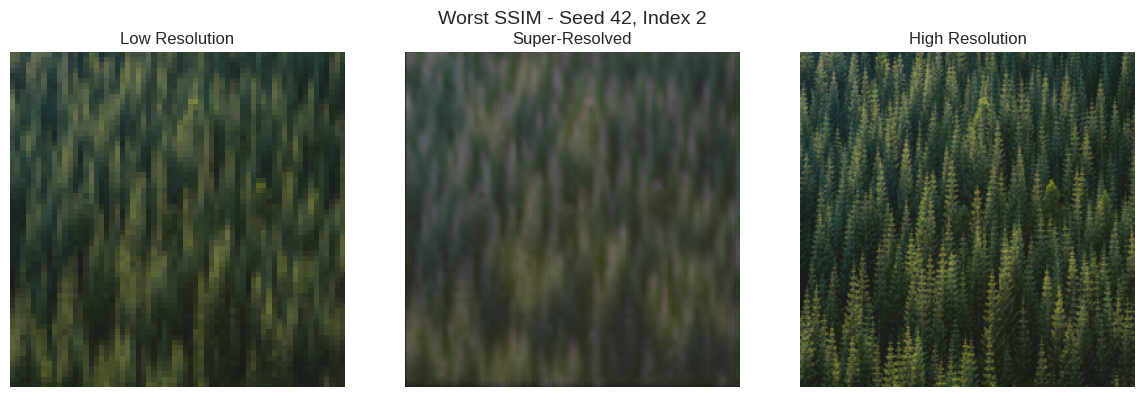

Saved: model2_results/qualitative_examples/worst_ssim_seed42_idx2.png


In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def tensor_to_img(path):
    return np.array(Image.open(path)) / 255.0

def show_and_save_triplet(model_name, seed, index, title_prefix):
    lr = tensor_to_img(f"{model_name}_examples/test_by_index/lr_seed{seed}_idx{index}.png")
    sr = tensor_to_img(f"{model_name}_examples/test_by_index/sr_seed{seed}_idx{index}.png")
    hr = tensor_to_img(f"{model_name}_examples/test_by_index/hr_seed{seed}_idx{index}.png")

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(lr)
    axs[0].set_title("Low Resolution")
    axs[1].imshow(sr)
    axs[1].set_title("Super-Resolved")
    axs[2].imshow(hr)
    axs[2].set_title("High Resolution")
    for ax in axs:
        ax.axis("off")
    plt.suptitle(f"{title_prefix} - Seed {seed}, Index {index}", fontsize=14)
    plt.tight_layout()

    save_dir = f"{model_name}_results/qualitative_examples"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{title_prefix.replace(' ', '_').lower()}_seed{seed}_idx{index}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Saved: {save_path}")

# Load per-image test metrics for model 2
model_name = "model2"
seed = 42
metrics = np.load(f"{model_name}_results/test_image_metrics_seed{seed}.npy", allow_pickle=True)

# Best/Worst PSNR
best_psnr  = max(metrics, key=lambda x: x["psnr"])
worst_psnr = min(metrics, key=lambda x: x["psnr"])

# Best/Worst SSIM
best_ssim  = max(metrics, key=lambda x: x["ssim"])
worst_ssim = min(metrics, key=lambda x: x["ssim"])

# Show and save 4 triplets
print("\n[Model 2] Best PSNR:")
show_and_save_triplet(model_name, seed, best_psnr["index"], "Best PSNR")

print("\n[Model 2] Worst PSNR:")
show_and_save_triplet(model_name, seed, worst_psnr["index"], "Worst PSNR")

print("\n[Model 2] Best SSIM:")
show_and_save_triplet(model_name, seed, best_ssim["index"], "Best SSIM")

print("\n[Model 2] Worst SSIM:")
show_and_save_triplet(model_name, seed, worst_ssim["index"], "Worst SSIM")

3.6 Results

Saved to comparison_both_models_performed_well.png


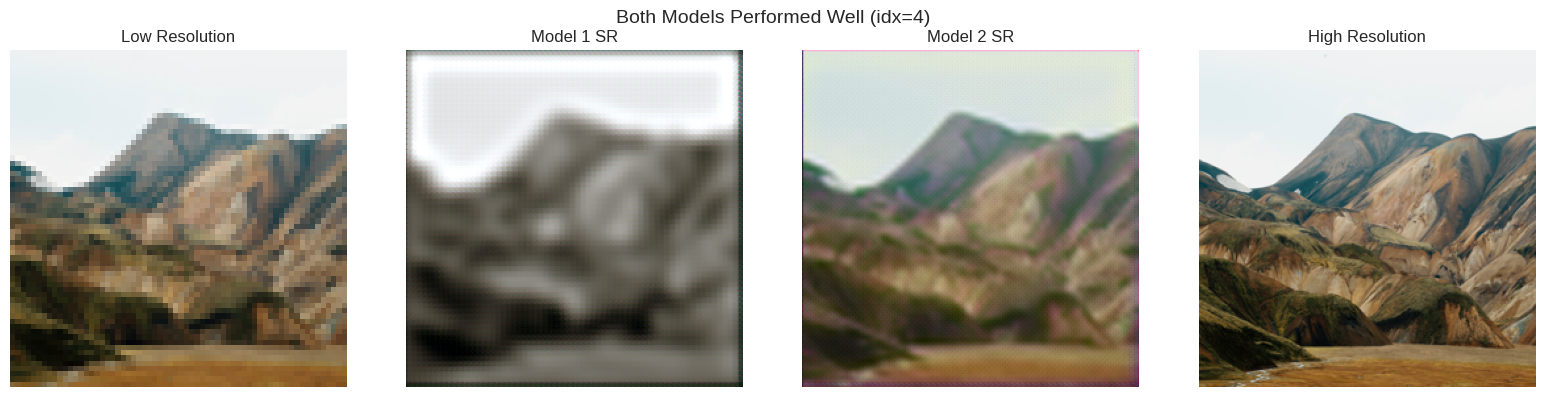

Saved to comparison_both_models_performed_poorly.png


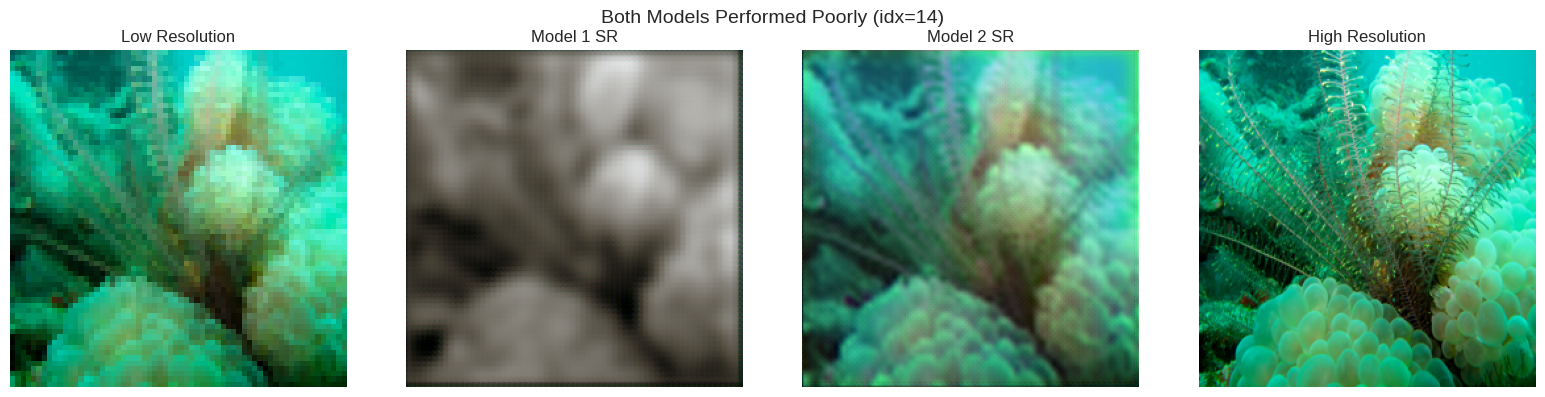

Saved to comparison_model_1_better_than_model_2.png


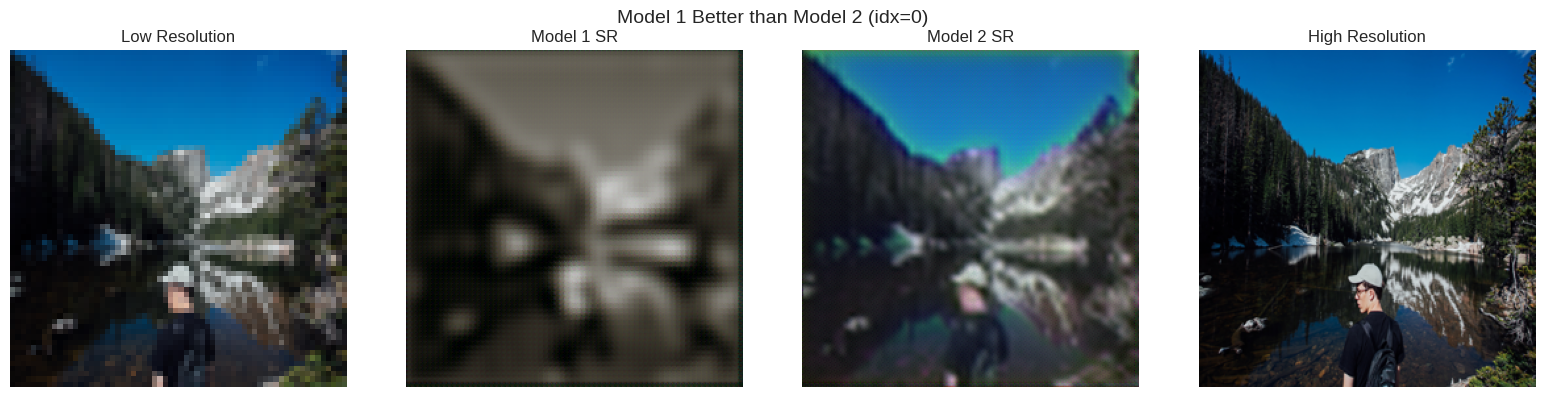

Saved to comparison_model_2_better_than_model_1.png


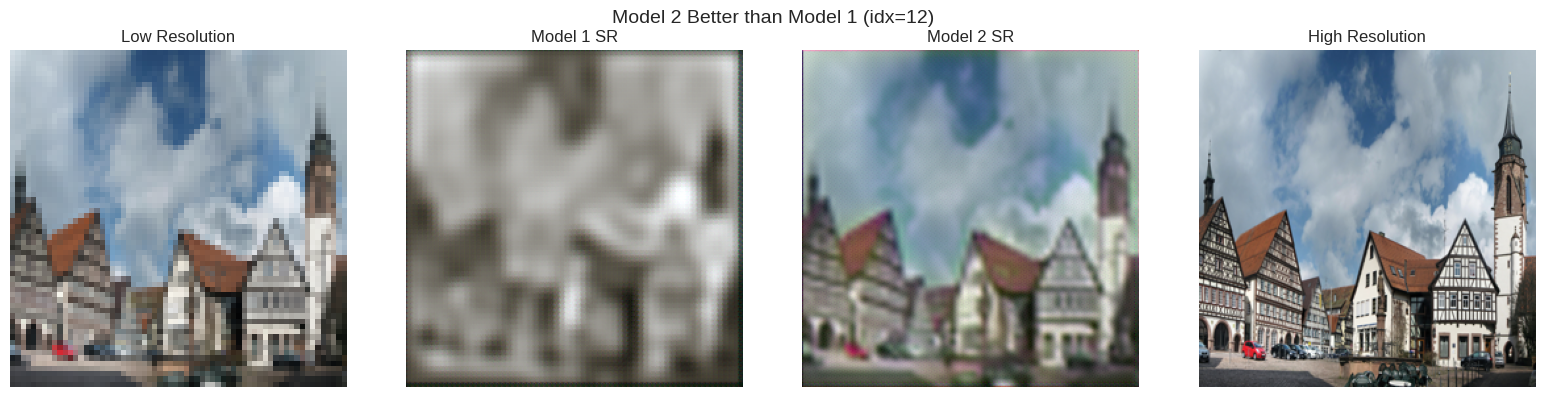

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Load metrics from both models (seed 42)
seed = 42
metrics1 = np.load(f"model1_results/test_image_metrics_seed{seed}.npy", allow_pickle=True)
metrics2 = np.load(f"model2_results/test_image_metrics_seed{seed}.npy", allow_pickle=True)

assert len(metrics1) == len(metrics2), "Mismatch in number of test samples"

# Normalize and combine
psnr1 = np.array([m['psnr'] for m in metrics1])
ssim1 = np.array([m['ssim'] for m in metrics1])
psnr2 = np.array([m['psnr'] for m in metrics2])
ssim2 = np.array([m['ssim'] for m in metrics2])

# Min-max normalization
def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())

norm1 = 0.5 * normalize(psnr1) + 0.5 * normalize(ssim1)
norm2 = 0.5 * normalize(psnr2) + 0.5 * normalize(ssim2)

combined = []
for i in range(len(metrics1)):
    combined.append({
        "index": i,
        "score1": norm1[i],
        "score2": norm2[i],
        "psnr1": psnr1[i],
        "ssim1": ssim1[i],
        "psnr2": psnr2[i],
        "ssim2": ssim2[i]
    })

# Find images
both_good = sorted(combined, key=lambda x: x['score1'] + x['score2'], reverse=True)[0]
both_bad  = sorted(combined, key=lambda x: x['score1'] + x['score2'])[0]
m1_better = sorted(combined, key=lambda x: x['score1'] - x['score2'], reverse=True)[0]
m2_better = sorted(combined, key=lambda x: x['score2'] - x['score1'], reverse=True)[0]

# Show and save images
def show_side_by_side_triplet(index, seed, title):
    def load_img(model, name):
        path = f"{model}_examples/test_by_index/{name}_seed{seed}_idx{index}.png"
        return np.array(Image.open(path)) / 255.0

    lr = load_img("model1", "lr")
    sr1 = load_img("model1", "sr")
    sr2 = load_img("model2", "sr")
    hr = load_img("model1", "hr")

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(lr);  axs[0].set_title("Low Resolution")
    axs[1].imshow(sr1); axs[1].set_title("Model 1 SR")
    axs[2].imshow(sr2); axs[2].set_title("Model 2 SR")
    axs[3].imshow(hr);  axs[3].set_title("High Resolution")
    for ax in axs: ax.axis("off")
    plt.suptitle(title + f" (idx={index})", fontsize=14)
    plt.tight_layout()

    out_path = f"comparison_{title.replace(' ', '_').lower()}.png"
    plt.savefig(out_path)
    print(f"Saved to {out_path}")
    plt.show()

# Display examples
show_side_by_side_triplet(both_good['index'], seed, "Both Models Performed Well")
show_side_by_side_triplet(both_bad['index'], seed, "Both Models Performed Poorly")
show_side_by_side_triplet(m1_better['index'], seed, "Model 1 Better than Model 2")
show_side_by_side_triplet(m2_better['index'], seed, "Model 2 Better than Model 1")

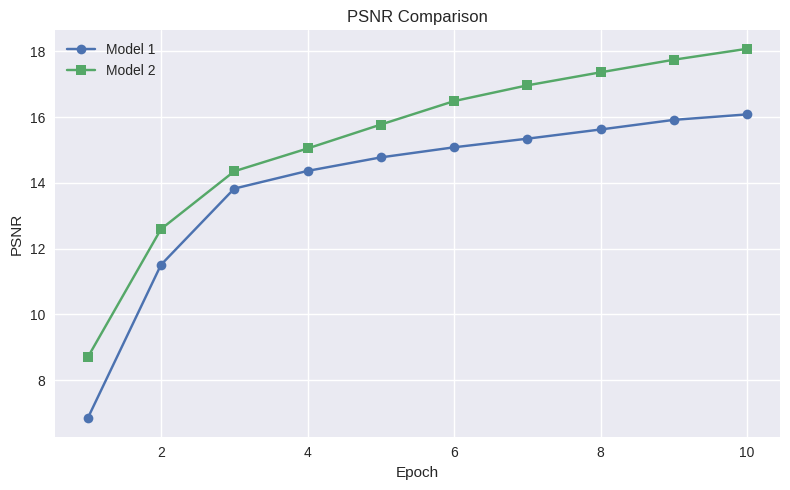

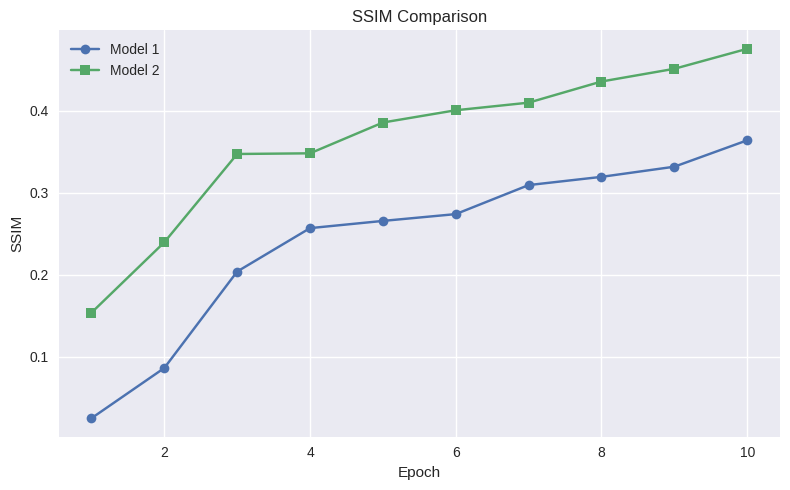

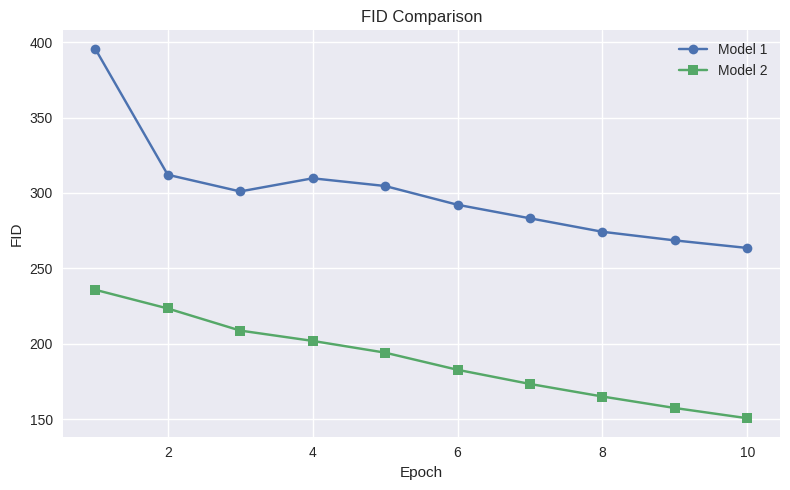

In [23]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(1, num_epochs + 1))

def plot_comparison(y1, y2, label, ylabel, filename):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, y1, label='Model 1', marker='o')
    plt.plot(epochs, y2, label='Model 2', marker='s')
    plt.title(f'{label} Comparison')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"model_comparison/{filename}")
    plt.show()

os.makedirs("model_comparison", exist_ok=True)

plot_comparison(mean_psnr_model1, mean_psnr_model2, "PSNR", "PSNR", "psnr_comparison.png")
plot_comparison(mean_ssim_model1, mean_ssim_model2, "SSIM", "SSIM", "ssim_comparison.png")
plot_comparison(mean_fid_model1,  mean_fid_model2,  "FID",  "FID",  "fid_comparison.png")

In [24]:
print("\n=== Final Test Set Comparison ===")
print(f"Model 1– PSNR: {mean_test_model1[1]:.2f} ± {std_test_model1[1]:.2f}")
print(f"Model 1– SSIM: {mean_test_model1[2]:.4f} ± {std_test_model1[2]:.4f}")
print(f"Model 1– FID:  {mean_test_model1[3]:.2f} ± {std_test_model1[3]:.2f}")
print()
print(f"Model 2– PSNR: {mean_test_model2[1]:.2f} ± {std_test_model2[1]:.2f}")
print(f"Model 2– SSIM: {mean_test_model2[2]:.4f} ± {std_test_model2[2]:.4f}")
print(f"Model 2– FID:  {mean_test_model2[3]:.2f} ± {std_test_model2[3]:.2f}")


=== Final Test Set Comparison ===
Model 1– PSNR: 15.97 ± 0.13
Model 1– SSIM: 0.3538 ± 0.0127
Model 1– FID:  305.46 ± 2.96

Model 2– PSNR: 18.13 ± 1.79
Model 2– SSIM: 0.4644 ± 0.0523
Model 2– FID:  207.29 ± 26.12


# Ablation Study:


In [25]:
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import save_image

def calculate_psnr(sr, hr):
    mse = nn.functional.mse_loss(sr, hr)
    return 20 * math.log10(1.0) - 10 * math.log10(mse.item()) if mse > 0 else float("inf")

def to_uint8(tensor):
    return tensor.clamp(0, 1).mul(255).to(torch.uint8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

seeds = [42, 55, 66]
num_epochs = 10
lambda_p = 0  # no perceptual loss

all_loss_ablation = []
all_psnr_ablation = []
all_ssim_ablation = []
all_fid_ablation = []

os.makedirs("ablation_results", exist_ok=True)
os.makedirs("ablation_examples/test_by_index", exist_ok=True)

for seed in seeds:
    print(f"\n--- Ablation Run with Seed {seed} ---")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = FSRCNN_Residual(scale_factor=4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    fid_metric = FrechetInceptionDistance(feature=2048).cpu()

    loss_list, psnr_list, ssim_list, fid_list = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()

        for batch in train_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            sr = model(lr)
            _, _, h, w = sr.shape
            hr = hr[:, :, :h, :w]

            loss = criterion(sr, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            total_psnr += calculate_psnr(sr, hr)
            total_ssim += structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

            fid_metric.update(to_uint8(sr).cpu(), real=False)
            fid_metric.update(to_uint8(hr).cpu(), real=True)

        avg_loss = epoch_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        avg_ssim = total_ssim / len(train_loader)
        fid_score = fid_metric.compute()

        loss_list.append(avg_loss)
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        fid_list.append(fid_score.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] – Loss: {avg_loss:.6f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f} | FID: {fid_score.item():.2f}")

    np.save(f"ablation_results/loss_seed{seed}.npy", np.array(loss_list))
    np.save(f"ablation_results/psnr_seed{seed}.npy", np.array(psnr_list))
    np.save(f"ablation_results/ssim_seed{seed}.npy", np.array(ssim_list))
    np.save(f"ablation_results/fid_seed{seed}.npy",  np.array(fid_list))

    all_loss_ablation.append(loss_list)
    all_psnr_ablation.append(psnr_list)
    all_ssim_ablation.append(ssim_list)
    all_fid_ablation.append(fid_list)

    def evaluate(loader, prefix):
        model.eval()
        total_loss = total_psnr = total_ssim = 0.0
        fid_metric.reset()
        per_image_metrics = []

        with torch.no_grad():
            for i, batch in enumerate(loader):
                lr = batch['lr'].to(device)
                hr = batch['hr'].to(device)
                sr = model(lr)
                _, _, h, w = sr.shape
                hr = hr[:, :, :h, :w]

                loss = criterion(sr, hr)
                psnr = calculate_psnr(sr, hr)
                ssim = structural_similarity_index_measure(sr[0:1], hr[0:1]).item()

                total_loss += loss.item()
                total_psnr += psnr
                total_ssim += ssim

                fid_metric.update(to_uint8(sr).cpu(), real=False)
                fid_metric.update(to_uint8(hr).cpu(), real=True)

                if prefix == "test":
                    save_image(lr[0], f"ablation_examples/test_by_index/lr_seed{seed}_idx{i}.png")
                    save_image(sr[0], f"ablation_examples/test_by_index/sr_seed{seed}_idx{i}.png")
                    save_image(hr[0], f"ablation_examples/test_by_index/hr_seed{seed}_idx{i}.png")
                    per_image_metrics.append({"index": i, "psnr": psnr, "ssim": ssim})

        avg_loss = total_loss / len(loader)
        avg_psnr = total_psnr / len(loader)
        avg_ssim = total_ssim / len(loader)
        fid = fid_metric.compute().item()

        return avg_loss, avg_psnr, avg_ssim, fid, per_image_metrics

    val_loss, val_psnr, val_ssim, val_fid, _ = evaluate(val_loader, "val")
    test_loss, test_psnr, test_ssim, test_fid, test_image_metrics = evaluate(test_loader, "test")

    print(f"→ Validation: Loss {val_loss:.6f}, PSNR {val_psnr:.2f}, SSIM {val_ssim:.4f}, FID {val_fid:.2f}")
    print(f"→ Test:       Loss {test_loss:.6f}, PSNR {test_psnr:.2f}, SSIM {test_ssim:.4f}, FID {test_fid:.2f}")

    np.save(f"ablation_results/val_metrics_seed{seed}.npy", np.array([val_loss, val_psnr, val_ssim, val_fid]))
    np.save(f"ablation_results/test_metrics_seed{seed}.npy", np.array([test_loss, test_psnr, test_ssim, test_fid]))
    np.save(f"ablation_results/test_image_metrics_seed{seed}.npy", test_image_metrics)

!mkdir -p /content/drive/MyDrive/deep_learning_results/ablation_results
!mkdir -p /content/drive/MyDrive/deep_learning_results/ablation_examples/test_by_index
!cp ablation_results/* /content/drive/MyDrive/deep_learning_results/ablation_results/
!cp ablation_examples/test_by_index/* /content/drive/MyDrive/deep_learning_results/ablation_examples/test_by_index/

Using device: Tesla T4

--- Ablation Run with Seed 42 ---


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch [1/10] – Loss: 0.075868 | PSNR: 11.44 | SSIM: 0.2304 | FID: 232.19
Epoch [2/10] – Loss: 0.038330 | PSNR: 14.23 | SSIM: 0.3326 | FID: 235.85
Epoch [3/10] – Loss: 0.030980 | PSNR: 15.19 | SSIM: 0.4251 | FID: 198.08
Epoch [4/10] – Loss: 0.024416 | PSNR: 16.23 | SSIM: 0.4296 | FID: 184.31
Epoch [5/10] – Loss: 0.017307 | PSNR: 17.69 | SSIM: 0.4540 | FID: 165.69
Epoch [6/10] – Loss: 0.014944 | PSNR: 18.31 | SSIM: 0.4874 | FID: 153.61
Epoch [7/10] – Loss: 0.013568 | PSNR: 18.73 | SSIM: 0.5164 | FID: 145.32
Epoch [8/10] – Loss: 0.012542 | PSNR: 19.09 | SSIM: 0.5464 | FID: 139.87
Epoch [9/10] – Loss: 0.011726 | PSNR: 19.39 | SSIM: 0.5402 | FID: 135.92
Epoch [10/10] – Loss: 0.011104 | PSNR: 19.64 | SSIM: 0.5470 | FID: 132.16
→ Validation: Loss 0.010425, PSNR 19.85, SSIM 0.5300, FID 195.68
→ Test:       Loss 0.010784, PSNR 19.71, SSIM 0.5579, FID 194.89

--- Ablation Run with Seed 55 ---
Epoch [1/10] – Loss: 0.110591 | PSNR: 9.85 | SSIM: 0.1132 | FID: 272.61
Epoch [2/10] – Loss: 0.046481 | 

In [26]:
model_ablation = model
print(model_ablation)

FSRCNN_Residual(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrinking): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (mapping): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): PReLU(num_parameters=1)
    (12): Conv2d(12, 12, kernel_size=(

3.7.2

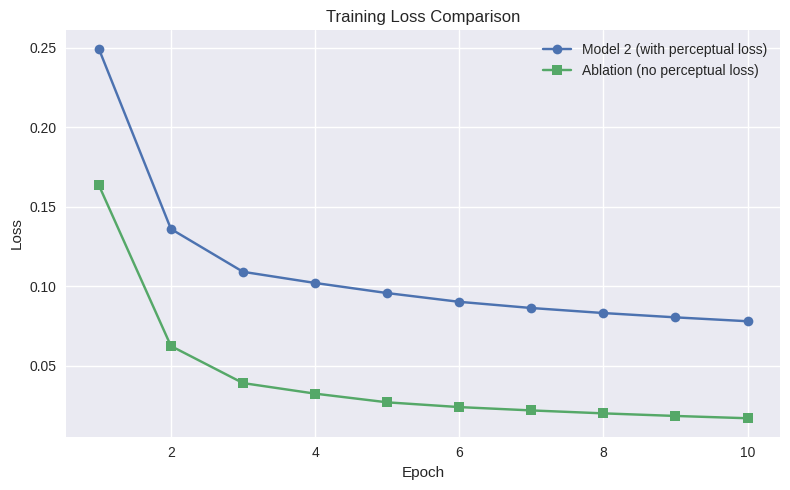

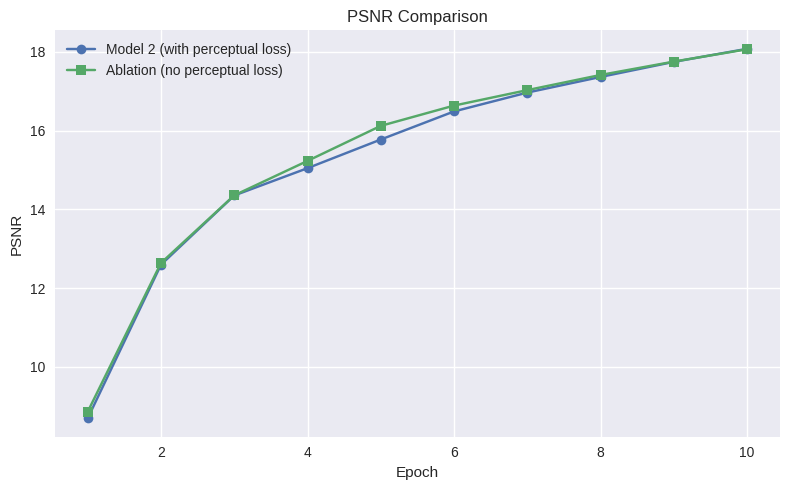

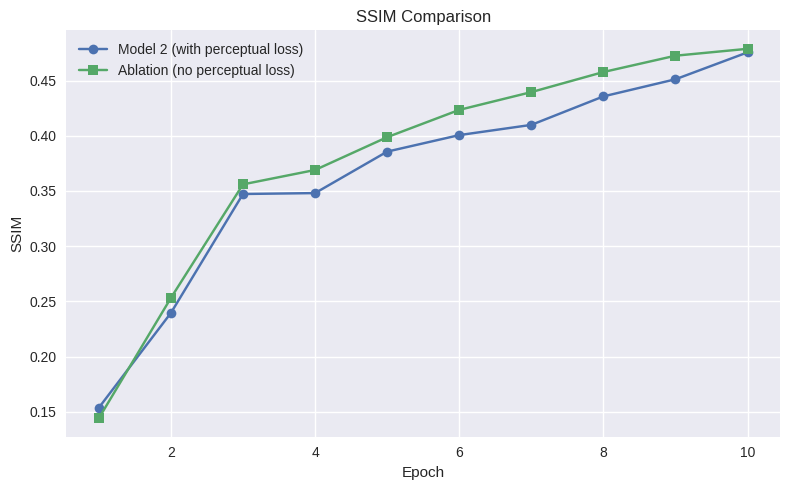

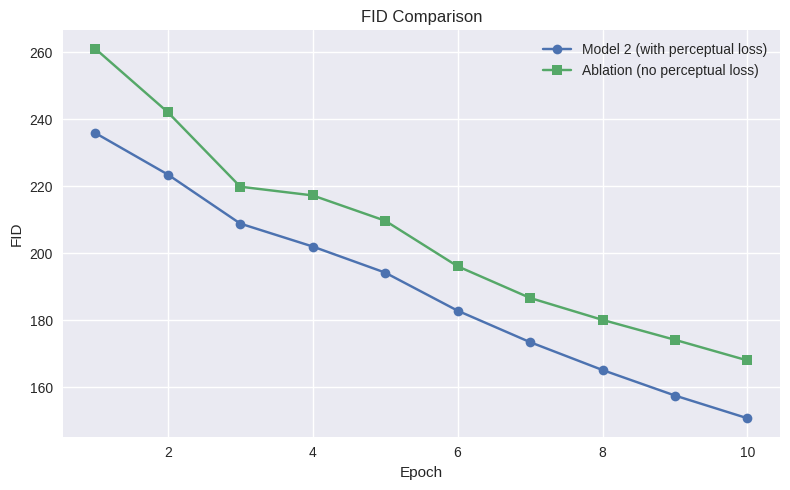

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("ablation_results", exist_ok=True)

epochs = list(range(1, num_epochs + 1))
# Convert to numpy arrays
loss_array_abl = np.array(all_loss_ablation)
psnr_array_abl = np.array(all_psnr_ablation)
ssim_array_abl = np.array(all_ssim_ablation)
fid_array_abl  = np.array(all_fid_ablation)

# Convert to numpy arrays
loss_array_abl = np.array(all_loss_ablation)
psnr_array_abl = np.array(all_psnr_ablation)
ssim_array_abl = np.array(all_ssim_ablation)
fid_array_abl  = np.array(all_fid_ablation)

# Compute mean and std per epoch (across seeds)
mean_loss_abl = np.mean(loss_array_abl, axis=0)
std_loss_abl  = np.std(loss_array_abl, axis=0)

mean_psnr_abl = np.mean(psnr_array_abl, axis=0)
std_psnr_abl  = np.std(psnr_array_abl, axis=0)

mean_ssim_abl = np.mean(ssim_array_abl, axis=0)
std_ssim_abl  = np.std(ssim_array_abl, axis=0)

mean_fid_abl  = np.mean(fid_array_abl, axis=0)
std_fid_abl   = np.std(fid_array_abl, axis=0)

def plot_metric_comparison(metric_name, mean_orig, mean_abl, ylabel, filename):
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_orig, label='Model 2 (with perceptual loss)', marker='o')
    plt.plot(epochs, mean_abl, label='Ablation (no perceptual loss)', marker='s')
    plt.title(f'{metric_name} Comparison')
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"ablation_results/{filename}")
    plt.show()

# Run for all 4 metrics
plot_metric_comparison("Training Loss", mean_loss_model2, mean_loss_abl, "Loss", "loss_comparison.png")
plot_metric_comparison("PSNR", mean_psnr_model2, mean_psnr_abl, "PSNR", "psnr_comparison.png")
plot_metric_comparison("SSIM", mean_ssim_model2, mean_ssim_abl, "SSIM", "ssim_comparison.png")
plot_metric_comparison("FID",  mean_fid_model2,  mean_fid_abl,  "FID",  "fid_comparison.png")

3.7.3

In [28]:
import numpy as np
import os
"""
# Convert to numpy arrays
loss_array_abl = np.array(all_loss_ablation)
psnr_array_abl = np.array(all_psnr_ablation)
ssim_array_abl = np.array(all_ssim_ablation)
fid_array_abl  = np.array(all_fid_ablation)

# Compute mean and std per epoch (across seeds)
mean_loss_abl = np.mean(loss_array_abl, axis=0)
std_loss_abl  = np.std(loss_array_abl, axis=0)

mean_psnr_abl = np.mean(psnr_array_abl, axis=0)
std_psnr_abl  = np.std(psnr_array_abl, axis=0)

mean_ssim_abl = np.mean(ssim_array_abl, axis=0)
std_ssim_abl  = np.std(ssim_array_abl, axis=0)

mean_fid_abl  = np.mean(fid_array_abl, axis=0)
std_fid_abl   = np.std(fid_array_abl, axis=0)
"""
# Create output lines
lines = []
lines.append("[Ablation Model] Epoch-wise Training Metrics (Mean ± Std)")
lines.append("Epoch |   Loss        |   PSNR         |   SSIM         |   FID")
lines.append("------------------------------------------------------------------")
for epoch in range(num_epochs):
    lines.append(f"{epoch+1:>5} | "
                 f"{mean_loss_abl[epoch]:.4f} ± {std_loss_abl[epoch]:.4f} | "
                 f"{mean_psnr_abl[epoch]:.2f} ± {std_psnr_abl[epoch]:.2f} | "
                 f"{mean_ssim_abl[epoch]:.4f} ± {std_ssim_abl[epoch]:.4f} | "
                 f"{mean_fid_abl[epoch]:.2f} ± {std_fid_abl[epoch]:.2f}")

# Print table
print("\n".join(lines))

# Save to file
os.makedirs("ablation_results", exist_ok=True)
with open("ablation_results/ablation_summary.txt", "w") as f:
    f.write("\n".join(lines))

# Backup to Drive
!cp ablation_results/ablation_summary.txt /content/drive/MyDrive/deep_learning_results/ablation_results/

[Ablation Model] Epoch-wise Training Metrics (Mean ± Std)
Epoch |   Loss        |   PSNR         |   SSIM         |   FID
------------------------------------------------------------------
    1 | 0.1636 ± 0.1005 | 8.86 ± 2.60 | 0.1441 ± 0.0618 | 261.00 ± 20.50
    2 | 0.0625 ± 0.0285 | 12.64 ± 1.74 | 0.2531 ± 0.0588 | 242.08 ± 10.74
    3 | 0.0392 ± 0.0132 | 14.36 ± 1.37 | 0.3560 ± 0.0522 | 219.85 ± 21.72
    4 | 0.0325 ± 0.0124 | 15.23 ± 1.54 | 0.3690 ± 0.0485 | 217.24 ± 26.42
    5 | 0.0271 ± 0.0120 | 16.12 ± 1.79 | 0.3987 ± 0.0417 | 209.69 ± 34.43
    6 | 0.0241 ± 0.0107 | 16.63 ± 1.80 | 0.4234 ± 0.0558 | 196.10 ± 40.44
    7 | 0.0220 ± 0.0097 | 17.03 ± 1.80 | 0.4395 ± 0.0642 | 186.65 ± 42.21
    8 | 0.0201 ± 0.0088 | 17.41 ± 1.78 | 0.4577 ± 0.0701 | 180.10 ± 41.35
    9 | 0.0185 ± 0.0078 | 17.75 ± 1.73 | 0.4725 ± 0.0492 | 174.15 ± 39.30
   10 | 0.0170 ± 0.0068 | 18.07 ± 1.64 | 0.4788 ± 0.0564 | 168.00 ± 36.40


3.7.4

Saved comparison to: ablation_results/qualitative_examples/example_idx0.png


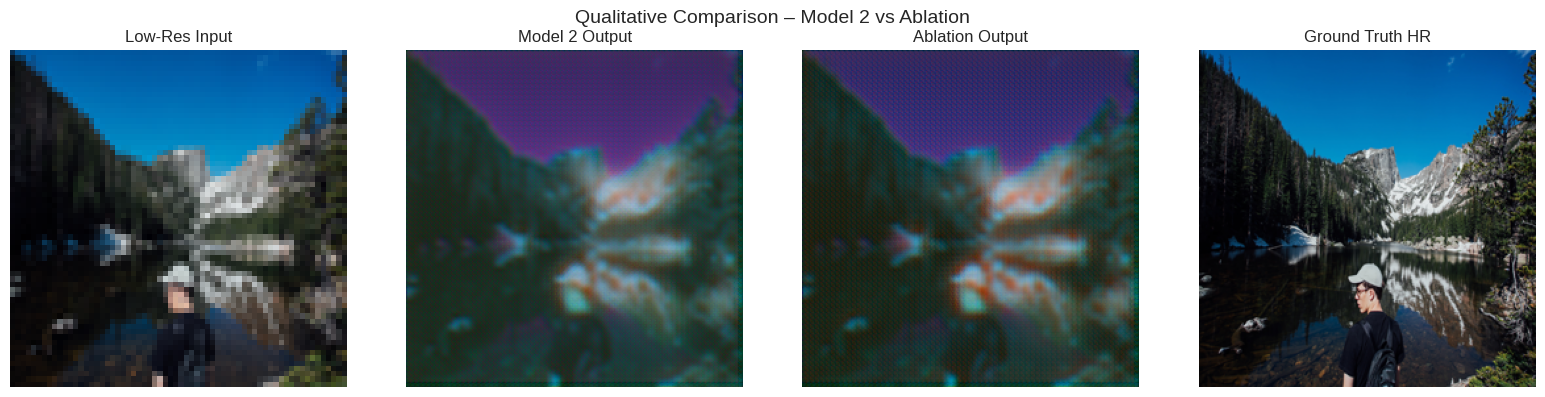

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# Set models to evaluation mode
model2.eval()
model_ablation.eval()

# Select a test sample (use test_loader for qualitative evaluation)
example_batch = next(iter(test_loader))
lr = example_batch['lr'].to(device)
hr = example_batch['hr'].to(device)

with torch.no_grad():
    sr_model2 = model2(lr)
    sr_ablation = model_ablation(lr)

# Ensure HR and SR match in size
_, _, h, w = sr_model2.shape
hr = hr[:, :, :h, :w]

# Choose an example index
idx = 0

# Convert tensors to images
def tensor_to_image(tensor):
    return tensor[idx].permute(1, 2, 0).cpu().numpy().clip(0, 1)

lr_img = tensor_to_image(lr)
sr2_img = tensor_to_image(sr_model2)
ablation_img = tensor_to_image(sr_ablation)
hr_img = tensor_to_image(hr)

# Plot and compare outputs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(lr_img)
axs[0].set_title("Low-Res Input")
axs[1].imshow(sr2_img)
axs[1].set_title("Model 2 Output")
axs[2].imshow(ablation_img)
axs[2].set_title("Ablation Output")
axs[3].imshow(hr_img)
axs[3].set_title("Ground Truth HR")

for ax in axs:
    ax.axis("off")

plt.suptitle("Qualitative Comparison – Model 2 vs Ablation", fontsize=14)
plt.tight_layout()

# Save result
os.makedirs("ablation_results/qualitative_examples", exist_ok=True)
out_path = "ablation_results/qualitative_examples/example_idx0.png"
plt.savefig(out_path)
print(f"Saved comparison to: {out_path}")
plt.show()

In [ ]:
import numpy as np

#Load Model 2 results
metrics_model2 = np.load("/content/drive/MyDrive/deep_learning_results/model2_results/test_image_metrics_seed42.npy", allow_pickle=True)

#Load Ablation results
metrics_ablation = np.load("/content/drive/MyDrive/deep_learning_results/ablation_results/test_image_metrics_seed42.npy", allow_pickle=True)

In [ ]:
#Score
psnr1 = np.array([m["psnr"] for m in metrics_model2])
ssim1 = np.array([m["ssim"] for m in metrics_model2])
psnr2 = np.array([m["psnr"] for m in metrics_ablation])
ssim2 = np.array([m["ssim"] for m in metrics_ablation])

def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())
score1 = 0.5 * normalize(psnr1) + 0.5 * normalize(ssim1)
score2 = 0.5 * normalize(psnr2) + 0.5 * normalize(ssim2)

#Check on which images Abl was better then model 2 (on the calculated scoring)
better_ablation_indices = np.where(score2 > score1)[0]
print("Indices where Ablation outperformed Model 2:", better_ablation_indices)